In [1]:
import sys
import os
from tqdm import tqdm
import random
import numpy as np
import math
# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

#import simtrain
from simtrain.sim_models_new import User_simmulation_Model, Conditioned_User_simmulation_Model, Toy_intensity_Comparer, all_in_one_model

from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain import explore_models, process_dat
from simtrain.train import train_function_approx_multiple_variational, train_density_multiple_variational_sorted

import simtrain.utils as utils
from simtrain.Dataset import CustomDataset, TimestepFrequencyDataset
from simtrain.train import train, train_with_negatives

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import ast

import paths
from os.path import join
import pytorch_warmup as warmup
from functools import partial
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
#num_items = 7
#num_items_per_recom = 2
num_interaction_types = 2
recom_dim = 1
#num_users = 11
#min_inter = 2
#max_inter = 4
state_size = SETTINGS.STATE_SIZE
subset = 20 # make data smaller
experiment_name = "intensity"
num_negatives = 150
conditioned=False
kl_weight=.01
state_size

4

# Data

## old

In [3]:
#create dataset from processed data
if False:
    train_dat, stg = process_dat.load_dat(paths.cw_stages['output_new']['train'], new_data=True)

    print(stg)

    def convert_string_to_double_list(s):
        return ast.literal_eval(s)

    # Apply the custom function
    train_dat['item_ids'] = train_dat['item_ids'].apply(convert_string_to_double_list)
    train_dat['user_means'] = train_dat['user_means'].apply(convert_string_to_double_list)
    train_dat['user_vars_log'] = train_dat['user_vars_log'].apply(convert_string_to_double_list)
    train_dat['timestamps'] = train_dat['timestamps'].apply(convert_string_to_double_list)
    train_dat['interaction_types'] = train_dat['interaction_types'].apply(convert_string_to_double_list)

    print("len: ", len(train_dat))
    list_of_dicts = train_dat.to_dict(orient='records')
    list_of_dicts = list_of_dicts[:subset]
    train_dat.head()


In [4]:
#checkpoint = torch.load(join(paths.dat, SETTINGS.rootpaths['models'],
#                             experiment_name, "data.h5"))
#list_of_dicts = checkpoint['data']

In [5]:
'''
def adjust_hidden_dim(data_dict, state_size):
    # just to jumstart experiments should be deleted at the end
    for row in list_of_dicts:
        if row["user_means"] > state_size:
            row["user_means"] = row["user_means"][:state_size]
            row["user_vars_log"] = row["user_vars_log"][:state_size]
        elif row["user_means"] > state_size:


adjust_hidden_dim(list_of_dicts, state_size)
'''


'\ndef adjust_hidden_dim(data_dict, state_size):\n    # just to jumstart experiments should be deleted at the end\n    for row in list_of_dicts:\n        if row["user_means"] > state_size:\n            row["user_means"] = row["user_means"][:state_size]\n            row["user_vars_log"] = row["user_vars_log"][:state_size]\n        elif row["user_means"] > state_size:\n\n\nadjust_hidden_dim(list_of_dicts, state_size)\n'

In [6]:
#dataset = CustomDataset(list_of_dicts[:subset]) # [:30]

#dataloader = DataLoader(dataset, batch_size=1, shuffle=True)# can only do batchsize 1

In [7]:
def test_data(dataloader):
    smallest = float("inf")
    biggest = -1
    count_classes = [0 for _ in range(num_interaction_types)]
    for batch in dataloader:
        timestamps, items, labels, means, var, idx = batch
        last = timestamps[0]
        smallest = min(smallest, last)
        biggest = max(biggest, timestamps[-1])
        for i in range(1,len(timestamps)):
            if timestamps[i] <= last:
                print("error, current: ", timestamps[i], "\tlast", last)
        
        for i in range(num_interaction_types):
            for row in labels:
                row=torch.as_tensor(row)
                count = torch.sum(row == i)
                count_classes[i] += count

    smallest, biggest= int(smallest), float(biggest)
    print(smallest), print(biggest)
    for i in range(num_interaction_types):
        print(f"number of interactions of type {i} = {count_classes[i]}")
    return biggest

#max_time = test_data(dataloader)

In [8]:
'''
for batch in dataloader:
    timestamps, items, labels, means, var, idx = batch
    print('Timestamps:', timestamps#, "\n dtype: ", timestamps.dtype
          )
    print('item_recom:', items#, "\n dtype: ", items.dtype
          )
    print('Labels:', labels#, "\n dtype: ", labels.dtype
          )
    print('means:', means#, "\n dtype: ", means.dtype
          )
    print('log_var:', var#, "\n dtype: ", var.dtype
          )
    break
    '''

'\nfor batch in dataloader:\n    timestamps, items, labels, means, var, idx = batch\n    print(\'Timestamps:\', timestamps#, "\n dtype: ", timestamps.dtype\n          )\n    print(\'item_recom:\', items#, "\n dtype: ", items.dtype\n          )\n    print(\'Labels:\', labels#, "\n dtype: ", labels.dtype\n          )\n    print(\'means:\', means#, "\n dtype: ", means.dtype\n          )\n    print(\'log_var:\', var#, "\n dtype: ", var.dtype\n          )\n    break\n    '

## new

In [3]:
train_sorted = False
batchsize = 64  # needs to be 1 for ode
centered_intervals = False

In [4]:
#create dataset from processed data
if True:
    train_dat, stg = process_dat.load_dat(paths.cw_stages['output_new']['train'], new_data=True)

    print(stg)

    def convert_string_to_double_list(s):
        return ast.literal_eval(s)

    # Apply the custom function
    train_dat['item_ids'] = train_dat['item_ids'].apply(convert_string_to_double_list)
    train_dat['user_means'] = train_dat['user_means'].apply(convert_string_to_double_list)
    train_dat['user_vars_log'] = train_dat['user_vars_log'].apply(convert_string_to_double_list)
    train_dat['timestamps'] = train_dat['timestamps'].apply(convert_string_to_double_list)
    train_dat['interaction_types'] = train_dat['interaction_types'].apply(convert_string_to_double_list)

    print("len: ", len(train_dat))
    list_of_dicts = train_dat.to_dict(orient='records')
    list_of_dicts = list_of_dicts[:subset]
    train_dat.head()


{'NI': 14, 'NU': 328, 'T': '[9.708333333333334, 12.4375, 12.604166666666666, 13.395833333333334, 15.458333333333334, 15.979166666666666, 17.333333333333332, 18.6875, 20.58333333333333, 21.354166666666668, 21.375, 21.39583333333333, 21.416666666666668, 21.4375, 21.45833333333333, 21.479166666666668, 22.52083333333333, 24.39583333333333, 24.416666666666668, 24.4375, 24.45833333333333, 24.479166666666668, 24.5, 24.52083333333333, 25.479166666666668, 25.5, 25.52083333333333, 25.541666666666668, 25.58333333333333, 25.64583333333333, 29.33333333333333, 30.14583333333333, 30.58333333333333, 30.604166666666668, 30.625, 30.979166666666668, 32.0, 34.354166666666664, 36.66666666666666, 36.6875, 37.5625, 37.583333333333336, 38.583333333333336, 43.10416666666666, 43.333333333333336]', 'NS': 100, 'INF_TIME': 1000}
len:  328


In [5]:
# create dataset

dataloader_list = []
#steps_per_epoch = 0 

for user in list_of_dicts:
    timestamps = user["timestamps"]
    means, logvars = user["user_means"], user["user_vars_log"]
    extras = {"user_id":user["user_id"]}
    #print(user["user_id"])
    reaction_ratio = [np.mean(np.array(row)) for row in user["interaction_types"]]
    dataset_for_user = TimestepFrequencyDataset(timestamps, num_random_points=num_negatives, 
                            reaction_ratio=reaction_ratio)

    dataloader = DataLoader(dataset_for_user, batch_size=batchsize, shuffle=not train_sorted
                        )
    dataloader_list.append([dataloader, means, logvars, extras])
    #steps_per_epoch += len(dataset) // batchsize  
    #if len(dataset) % batchsize != 0:
    #    steps_per_epoch += 1
steps_per_epoch = 64# for 64b 80u, for 16b 20u: 221, for 64b u20: 63, 

if batchsize==1 and train_sorted:
    steps_per_epoch = 20
steps_per_epoch

save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios
save interaction ratios


64

In [6]:
sum(len(data[0]) for data in dataloader_list)

63

In [7]:
ids= [188,491,561,670,749,800,879,931,1372,1480,1622,2118,2249,2290,2725,2808,2839,2905,2920, 3059]

In [8]:
path_list = []
for user in list_of_dicts:
    timestamps = user["timestamps"]
    means, logvars = user["user_means"], user["user_vars_log"]
    reaction_ratio = [np.mean(np.array(row)) for row in user["interaction_types"]]
    extras = {"user_id":user["user_id"]}
    path_list.append([user["timestamps"], means, logvars, reaction_ratio, extras])

# model

## Density

In [22]:
width = 64
model_type = "simple"
use_variational_nn = True
state_consistancy_training = False
use_jump = False
timecheat = False

intensity = {"model_hyp": {"layer_width": [width for _ in range(3)],
                           "bayesian": use_variational_nn,
                           }}
state_dict = {"model_hyp": {"layer_width": [width for _ in range(4)],
                            "noise": 0, "bayesian": use_variational_nn,},
            }
jump_dict= {"model_hyp": {"layer_width": [8, 8]}
            }
hyperparameter_dict = {"state_size": state_size, "state_model": state_dict, 
        "intensity_model": intensity, "state_model_type": model_type, # simple
        #"jump_model": jump_dict,
        "time_embedding_size" :32, "max_freq": 30,
        }
if use_jump:
 hyperparameter_dict["jump_model"] =jump_dict
model = Toy_intensity_Comparer(hyperparameter_dict)
print(model)

bayesian
Toy_intensity_Comparer(
  (embed): SignWaveEmbedding()
  (user_state_model): Base_Model(
    (model): Sequential(
      (0): Linear(in_features=37, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): SiLU()
      (8): Linear(in_features=64, out_features=4, bias=True)
    )
  )
  (intensity_model): User_State_Intensity_Model_simple(
    (model): Sequential(
      (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=64, bias=True)
      (1): SiLU()
      (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=

In [23]:
from simtrain.utils import weighted_mse_loss
from simtrain.train import train_density_multiple_variational

loss = partial(weighted_mse_loss, weight_pos=10)
loss_func_kl=partial(utils.kl_divergence, mu2=0, sigma2=0.01)

In [24]:
num_epochs = 2001
warmup_period = steps_per_epoch
num_steps = num_epochs*steps_per_epoch - warmup_period
num_iter_til_first_restart = (num_steps + 1)//15
# restarts seem to ne be great most of the time here
user_lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=user_lr,
                        weight_decay=1e-10)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=1e-5)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)
num_iter_til_first_restart

Using device: cpu


8533

In [25]:
if train_sorted:
    train_density_multiple_variational_sorted(model, dataloader_list, criterion=weighted_mse_loss, 
            state_size=state_size, user_lr_decay=0.995, train_bayesian_weight= 0.1,
            optimizer=optimizer, num_epochs=num_epochs, warmup_scheduler=warmup_scheduler,
            loss_func_kl=loss_func_kl, kl_weight=kl_weight, user_lr=.02, device=device, 
            loss_print_interval=25, warmup_period=warmup_period, lr_scheduler=lr_scheduler,
            logging_shift = 1, model_type=model_type, use_jump=use_jump)
else:
    results =train_density_multiple_variational(model, dataloader_list, criterion=weighted_mse_loss, 
            state_size=state_size, user_lr_decay=0.995, train_bayesian_weight= 0.1,
            state_consistancy_training=state_consistancy_training, consistancy_weight=.5,
            optimizer=optimizer, num_epochs=num_epochs, warmup_scheduler=warmup_scheduler,
            loss_func_kl=loss_func_kl, kl_weight=kl_weight, user_lr=.02, device=device, 
            loss_print_interval=25, warmup_period=warmup_period, lr_scheduler=lr_scheduler,
            logging_shift = 1)


  0%|          | 0/2001 [00:00<?, ?it/s]/home/thahit/github/Recommender_Sim/simtrain/train.py:506: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=True).to(device), torch.tensor(variational_logvar, requires_grad=True).to(device)
/home/thahit/anaconda3/envs/WWcopy/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:1360: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 1/2001 [00:00<20:51,  1.60it/s]

epoch: 2 loss_sum_all: 18979.825, loss_sum_freq: 18947.637, loss_sum_kl: 29.697, loss_state_consistancy: 0.000, lr: 0.0010000, userlr: 0.0200000


  1%|▏         | 26/2001 [00:12<11:40,  2.82it/s]

epoch: 27 loss_sum_all: 6695.041, loss_sum_freq: 6603.388, loss_sum_kl: 89.002, loss_state_consistancy: 0.000, lr: 0.0009202, userlr: 0.0176444


  3%|▎         | 51/2001 [00:24<18:36,  1.75it/s]

epoch: 52 loss_sum_all: 7490.517, loss_sum_freq: 7347.545, loss_sum_kl: 140.209, loss_state_consistancy: 0.000, lr: 0.0007025, userlr: 0.0155663


  4%|▍         | 76/2001 [00:38<18:13,  1.76it/s]

epoch: 77 loss_sum_all: 4880.020, loss_sum_freq: 4750.859, loss_sum_kl: 126.392, loss_state_consistancy: 0.000, lr: 0.0004222, userlr: 0.0137329


  5%|▌         | 101/2001 [00:51<09:59,  3.17it/s]

epoch: 102 loss_sum_all: 6778.261, loss_sum_freq: 6217.246, loss_sum_kl: 557.991, loss_state_consistancy: 0.000, lr: 0.0001667, userlr: 0.0121154


  6%|▋         | 126/2001 [00:59<14:47,  2.11it/s]

epoch: 127 loss_sum_all: 5380.163, loss_sum_freq: 5106.651, loss_sum_kl: 270.630, loss_state_consistancy: 0.000, lr: 0.0000237, userlr: 0.0106885


  8%|▊         | 151/2001 [01:09<07:59,  3.85it/s]

epoch: 152 loss_sum_all: 7851.396, loss_sum_freq: 7580.861, loss_sum_kl: 267.396, loss_state_consistancy: 0.000, lr: 0.0009712, userlr: 0.0094296


  9%|▉         | 176/2001 [01:18<10:30,  2.89it/s]

epoch: 177 loss_sum_all: 5252.494, loss_sum_freq: 4789.236, loss_sum_kl: 460.105, loss_state_consistancy: 0.000, lr: 0.0008053, userlr: 0.0083190


 10%|█         | 201/2001 [01:28<15:54,  1.89it/s]

epoch: 202 loss_sum_all: 2308.719, loss_sum_freq: 2191.531, loss_sum_kl: 114.060, loss_state_consistancy: 0.000, lr: 0.0005430, userlr: 0.0073392


 11%|█▏        | 226/2001 [01:36<08:31,  3.47it/s]

epoch: 227 loss_sum_all: 4312.992, loss_sum_freq: 4002.052, loss_sum_kl: 307.655, loss_state_consistancy: 0.000, lr: 0.0002655, userlr: 0.0064748


 13%|█▎        | 251/2001 [01:44<11:24,  2.56it/s]

epoch: 252 loss_sum_all: 2665.430, loss_sum_freq: 2511.683, loss_sum_kl: 150.498, loss_state_consistancy: 0.000, lr: 0.0000673, userlr: 0.0057122


 14%|█▍        | 276/2001 [01:56<19:52,  1.45it/s]

epoch: 277 loss_sum_all: 6081.577, loss_sum_freq: 5759.571, loss_sum_kl: 318.812, loss_state_consistancy: 0.000, lr: 0.0009976, userlr: 0.0050394


 15%|█▌        | 301/2001 [02:09<15:35,  1.82it/s]

epoch: 302 loss_sum_all: 3643.098, loss_sum_freq: 3228.908, loss_sum_kl: 411.053, loss_state_consistancy: 0.000, lr: 0.0008906, userlr: 0.0044458


 16%|█▋        | 326/2001 [02:17<07:07,  3.91it/s]

epoch: 327 loss_sum_all: 4137.632, loss_sum_freq: 3880.708, loss_sum_kl: 253.752, loss_state_consistancy: 0.000, lr: 0.0006582, userlr: 0.0039222


 18%|█▊        | 351/2001 [02:23<06:17,  4.37it/s]

epoch: 352 loss_sum_all: 3353.498, loss_sum_freq: 3030.492, loss_sum_kl: 319.673, loss_state_consistancy: 0.000, lr: 0.0003756, userlr: 0.0034603


 19%|█▉        | 376/2001 [02:31<13:41,  1.98it/s]

epoch: 377 loss_sum_all: 3287.730, loss_sum_freq: 2971.797, loss_sum_kl: 312.532, loss_state_consistancy: 0.000, lr: 0.0001335, userlr: 0.0030527


 20%|██        | 401/2001 [02:38<06:09,  4.34it/s]

epoch: 402 loss_sum_all: 1859.041, loss_sum_freq: 1605.401, loss_sum_kl: 250.370, loss_state_consistancy: 0.000, lr: 0.0000148, userlr: 0.0026932


 21%|██▏       | 426/2001 [02:47<07:47,  3.37it/s]

epoch: 427 loss_sum_all: 4466.828, loss_sum_freq: 4286.941, loss_sum_kl: 176.725, loss_state_consistancy: 0.000, lr: 0.0009519, userlr: 0.0023760


 23%|██▎       | 451/2001 [02:54<05:59,  4.32it/s]

epoch: 452 loss_sum_all: 2742.439, loss_sum_freq: 2461.239, loss_sum_kl: 277.918, loss_state_consistancy: 0.000, lr: 0.0007604, userlr: 0.0020961


 24%|██▍       | 476/2001 [03:01<11:48,  2.15it/s]

epoch: 477 loss_sum_all: 2567.691, loss_sum_freq: 2294.500, loss_sum_kl: 269.915, loss_state_consistancy: 0.000, lr: 0.0004871, userlr: 0.0018492


 25%|██▌       | 501/2001 [03:10<06:06,  4.10it/s]

epoch: 502 loss_sum_all: 1757.880, loss_sum_freq: 1554.418, loss_sum_kl: 200.211, loss_state_consistancy: 0.000, lr: 0.0002198, userlr: 0.0016314


 26%|██▋       | 526/2001 [03:23<13:51,  1.77it/s]

epoch: 527 loss_sum_all: 1821.030, loss_sum_freq: 1655.237, loss_sum_kl: 162.570, loss_state_consistancy: 0.000, lr: 0.0000453, userlr: 0.0014393


 28%|██▊       | 551/2001 [03:36<09:31,  2.54it/s]

epoch: 552 loss_sum_all: 3692.106, loss_sum_freq: 3468.416, loss_sum_kl: 220.538, loss_state_consistancy: 0.000, lr: 0.0009904, userlr: 0.0012698


 29%|██▉       | 576/2001 [03:47<12:02,  1.97it/s]

epoch: 577 loss_sum_all: 2667.392, loss_sum_freq: 2473.264, loss_sum_kl: 190.892, loss_state_consistancy: 0.000, lr: 0.0008604, userlr: 0.0011202


 30%|███       | 601/2001 [03:57<12:59,  1.80it/s]

epoch: 602 loss_sum_all: 1388.594, loss_sum_freq: 1236.090, loss_sum_kl: 149.411, loss_state_consistancy: 0.000, lr: 0.0006162, userlr: 0.0009883


 31%|███▏      | 626/2001 [04:06<05:37,  4.07it/s]

epoch: 627 loss_sum_all: 2042.313, loss_sum_freq: 1865.349, loss_sum_kl: 173.874, loss_state_consistancy: 0.000, lr: 0.0003351, userlr: 0.0008719


 33%|███▎      | 651/2001 [04:13<05:15,  4.27it/s]

epoch: 652 loss_sum_all: 1363.450, loss_sum_freq: 1182.249, loss_sum_kl: 178.043, loss_state_consistancy: 0.000, lr: 0.0001078, userlr: 0.0007692


 34%|███▍      | 676/2001 [04:20<05:19,  4.15it/s]

epoch: 677 loss_sum_all: 1469.364, loss_sum_freq: 1235.053, loss_sum_kl: 231.027, loss_state_consistancy: 0.000, lr: 0.0000109, userlr: 0.0006786


 35%|███▌      | 701/2001 [04:26<05:08,  4.22it/s]

epoch: 702 loss_sum_all: 1562.914, loss_sum_freq: 1441.650, loss_sum_kl: 118.159, loss_state_consistancy: 0.000, lr: 0.0009330, userlr: 0.0005987


 36%|███▋      | 726/2001 [04:35<09:32,  2.23it/s]

epoch: 727 loss_sum_all: 1791.324, loss_sum_freq: 1599.823, loss_sum_kl: 188.267, loss_state_consistancy: 0.000, lr: 0.0007284, userlr: 0.0005282


 38%|███▊      | 751/2001 [04:43<09:00,  2.31it/s]

epoch: 752 loss_sum_all: 1918.734, loss_sum_freq: 1695.721, loss_sum_kl: 219.723, loss_state_consistancy: 0.000, lr: 0.0004485, userlr: 0.0004660


 39%|███▉      | 776/2001 [04:52<09:24,  2.17it/s]

epoch: 777 loss_sum_all: 1227.108, loss_sum_freq: 905.116, loss_sum_kl: 318.607, loss_state_consistancy: 0.000, lr: 0.0001876, userlr: 0.0004111


 40%|████      | 801/2001 [05:00<05:49,  3.44it/s]

epoch: 802 loss_sum_all: 1239.577, loss_sum_freq: 1089.506, loss_sum_kl: 146.759, loss_state_consistancy: 0.000, lr: 0.0000311, userlr: 0.0003627


 41%|████▏     | 826/2001 [05:09<11:34,  1.69it/s]

epoch: 827 loss_sum_all: 1217.619, loss_sum_freq: 1118.291, loss_sum_kl: 96.209, loss_state_consistancy: 0.000, lr: 0.0009794, userlr: 0.0003199


 43%|████▎     | 851/2001 [05:23<12:44,  1.50it/s]

epoch: 852 loss_sum_all: 2698.232, loss_sum_freq: 2492.540, loss_sum_kl: 202.279, loss_state_consistancy: 0.000, lr: 0.0008231, userlr: 0.0002823


 44%|████▍     | 876/2001 [05:38<07:44,  2.42it/s]

epoch: 877 loss_sum_all: 1622.004, loss_sum_freq: 1457.806, loss_sum_kl: 160.869, loss_state_consistancy: 0.000, lr: 0.0005627, userlr: 0.0002490


 45%|████▌     | 901/2001 [05:48<06:15,  2.93it/s]

epoch: 902 loss_sum_all: 1349.532, loss_sum_freq: 1028.424, loss_sum_kl: 317.750, loss_state_consistancy: 0.000, lr: 0.0002826, userlr: 0.0002197


 46%|████▋     | 926/2001 [05:57<06:25,  2.79it/s]

epoch: 927 loss_sum_all: 1028.073, loss_sum_freq: 813.595, loss_sum_kl: 211.172, loss_state_consistancy: 0.000, lr: 0.0000754, userlr: 0.0001938


 48%|████▊     | 951/2001 [06:10<11:15,  1.55it/s]

epoch: 952 loss_sum_all: 2005.287, loss_sum_freq: 1781.834, loss_sum_kl: 220.216, loss_state_consistancy: 0.000, lr: 0.0009991, userlr: 0.0001710


 49%|████▉     | 976/2001 [06:26<11:46,  1.45it/s]

epoch: 977 loss_sum_all: 1860.903, loss_sum_freq: 1630.322, loss_sum_kl: 227.410, loss_state_consistancy: 0.000, lr: 0.0009026, userlr: 0.0001508


 50%|█████     | 1001/2001 [06:38<08:43,  1.91it/s]

epoch: 1002 loss_sum_all: 843.022, loss_sum_freq: 619.847, loss_sum_kl: 220.154, loss_state_consistancy: 0.000, lr: 0.0006730, userlr: 0.0001331


 51%|█████▏    | 1026/2001 [06:49<07:41,  2.11it/s]

epoch: 1027 loss_sum_all: 970.462, loss_sum_freq: 813.983, loss_sum_kl: 153.464, loss_state_consistancy: 0.000, lr: 0.0003909, userlr: 0.0001174


 53%|█████▎    | 1051/2001 [07:00<06:11,  2.56it/s]

epoch: 1052 loss_sum_all: 588.175, loss_sum_freq: 447.023, loss_sum_kl: 138.254, loss_state_consistancy: 0.000, lr: 0.0001465, userlr: 0.0001036


 54%|█████▍    | 1076/2001 [07:12<05:28,  2.82it/s]

epoch: 1077 loss_sum_all: 626.959, loss_sum_freq: 532.196, loss_sum_kl: 91.871, loss_state_consistancy: 0.000, lr: 0.0000180, userlr: 0.0000914


 55%|█████▌    | 1101/2001 [07:21<05:10,  2.90it/s]

epoch: 1102 loss_sum_all: 1566.461, loss_sum_freq: 1414.427, loss_sum_kl: 149.204, loss_state_consistancy: 0.000, lr: 0.0009597, userlr: 0.0000806


 56%|█████▋    | 1126/2001 [07:31<06:24,  2.28it/s]

epoch: 1127 loss_sum_all: 1071.871, loss_sum_freq: 992.774, loss_sum_kl: 76.375, loss_state_consistancy: 0.000, lr: 0.0007768, userlr: 0.0000711


 58%|█████▊    | 1151/2001 [07:42<05:14,  2.71it/s]

epoch: 1152 loss_sum_all: 523.849, loss_sum_freq: 439.180, loss_sum_kl: 81.981, loss_state_consistancy: 0.000, lr: 0.0005073, userlr: 0.0000627


 59%|█████▉    | 1176/2001 [07:54<09:06,  1.51it/s]

epoch: 1177 loss_sum_all: 656.921, loss_sum_freq: 546.171, loss_sum_kl: 108.104, loss_state_consistancy: 0.000, lr: 0.0002343, userlr: 0.0000554


 60%|██████    | 1201/2001 [08:10<08:27,  1.58it/s]

epoch: 1202 loss_sum_all: 889.242, loss_sum_freq: 744.836, loss_sum_kl: 141.744, loss_state_consistancy: 0.000, lr: 0.0000526, userlr: 0.0000488


 61%|██████▏   | 1226/2001 [08:23<07:21,  1.76it/s]

epoch: 1227 loss_sum_all: 1573.800, loss_sum_freq: 1362.016, loss_sum_kl: 208.903, loss_state_consistancy: 0.000, lr: 0.0009935, userlr: 0.0000431


 63%|██████▎   | 1251/2001 [08:36<04:23,  2.85it/s]

epoch: 1252 loss_sum_all: 1377.766, loss_sum_freq: 1217.246, loss_sum_kl: 157.731, loss_state_consistancy: 0.000, lr: 0.0008709, userlr: 0.0000380


 64%|██████▍   | 1276/2001 [08:51<08:41,  1.39it/s]

epoch: 1277 loss_sum_all: 1652.880, loss_sum_freq: 1365.842, loss_sum_kl: 284.185, loss_state_consistancy: 0.000, lr: 0.0006288, userlr: 0.0000335


 65%|██████▌   | 1301/2001 [09:08<06:38,  1.76it/s]

epoch: 1302 loss_sum_all: 625.321, loss_sum_freq: 509.434, loss_sum_kl: 113.284, loss_state_consistancy: 0.000, lr: 0.0003468, userlr: 0.0000296


 66%|██████▋   | 1326/2001 [09:17<03:41,  3.05it/s]

epoch: 1327 loss_sum_all: 659.927, loss_sum_freq: 592.028, loss_sum_kl: 65.488, loss_state_consistancy: 0.000, lr: 0.0001176, userlr: 0.0000261


 68%|██████▊   | 1351/2001 [09:28<04:23,  2.47it/s]

epoch: 1352 loss_sum_all: 469.881, loss_sum_freq: 353.342, loss_sum_kl: 114.027, loss_state_consistancy: 0.000, lr: 0.0000121, userlr: 0.0000230


 69%|██████▉   | 1376/2001 [09:40<06:59,  1.49it/s]

epoch: 1377 loss_sum_all: 1089.074, loss_sum_freq: 986.912, loss_sum_kl: 99.549, loss_state_consistancy: 0.000, lr: 0.0009422, userlr: 0.0000203


 70%|███████   | 1401/2001 [09:55<05:53,  1.69it/s]

epoch: 1402 loss_sum_all: 756.083, loss_sum_freq: 625.535, loss_sum_kl: 127.875, loss_state_consistancy: 0.000, lr: 0.0007453, userlr: 0.0000179


 71%|███████▏  | 1426/2001 [10:09<03:34,  2.67it/s]

epoch: 1427 loss_sum_all: 923.343, loss_sum_freq: 789.238, loss_sum_kl: 131.473, loss_state_consistancy: 0.000, lr: 0.0004681, userlr: 0.0000158


 73%|███████▎  | 1451/2001 [10:22<05:49,  1.57it/s]

epoch: 1452 loss_sum_all: 392.410, loss_sum_freq: 317.949, loss_sum_kl: 72.036, loss_state_consistancy: 0.000, lr: 0.0002050, userlr: 0.0000139


 74%|███████▍  | 1476/2001 [10:33<03:30,  2.49it/s]

epoch: 1477 loss_sum_all: 798.362, loss_sum_freq: 596.433, loss_sum_kl: 199.371, loss_state_consistancy: 0.000, lr: 0.0000389, userlr: 0.0000123


 75%|███████▌  | 1501/2001 [10:47<04:40,  1.78it/s]

epoch: 1502 loss_sum_all: 986.227, loss_sum_freq: 827.098, loss_sum_kl: 156.666, loss_state_consistancy: 0.000, lr: 0.0009860, userlr: 0.0000109


 76%|███████▋  | 1526/2001 [11:00<02:48,  2.83it/s]

epoch: 1527 loss_sum_all: 1128.698, loss_sum_freq: 1011.207, loss_sum_kl: 114.912, loss_state_consistancy: 0.000, lr: 0.0008455, userlr: 0.0000096


 78%|███████▊  | 1551/2001 [11:14<04:17,  1.74it/s]

epoch: 1552 loss_sum_all: 764.175, loss_sum_freq: 638.376, loss_sum_kl: 123.337, loss_state_consistancy: 0.000, lr: 0.0005948, userlr: 0.0000084


 79%|███████▉  | 1576/2001 [11:27<04:47,  1.48it/s]

epoch: 1577 loss_sum_all: 617.413, loss_sum_freq: 475.974, loss_sum_kl: 139.060, loss_state_consistancy: 0.000, lr: 0.0003124, userlr: 0.0000075


 80%|████████  | 1601/2001 [11:42<03:44,  1.78it/s]

epoch: 1602 loss_sum_all: 382.660, loss_sum_freq: 307.903, loss_sum_kl: 72.483, loss_state_consistancy: 0.000, lr: 0.0000950, userlr: 0.0000066


 81%|████████▏ | 1626/2001 [11:57<04:09,  1.50it/s]

epoch: 1627 loss_sum_all: 486.932, loss_sum_freq: 429.017, loss_sum_kl: 55.689, loss_state_consistancy: 0.000, lr: 0.0000100, userlr: 0.0000058


 83%|████████▎ | 1651/2001 [12:09<03:07,  1.87it/s]

epoch: 1652 loss_sum_all: 1012.310, loss_sum_freq: 878.292, loss_sum_kl: 131.656, loss_state_consistancy: 0.000, lr: 0.0009217, userlr: 0.0000051


 84%|████████▍ | 1676/2001 [12:21<03:40,  1.48it/s]

epoch: 1677 loss_sum_all: 530.587, loss_sum_freq: 469.179, loss_sum_kl: 59.174, loss_state_consistancy: 0.000, lr: 0.0007076, userlr: 0.0000045


 85%|████████▌ | 1701/2001 [12:34<02:00,  2.48it/s]

epoch: 1702 loss_sum_all: 700.379, loss_sum_freq: 493.044, loss_sum_kl: 205.060, loss_state_consistancy: 0.000, lr: 0.0004278, userlr: 0.0000040


 86%|████████▋ | 1726/2001 [12:44<01:30,  3.05it/s]

epoch: 1727 loss_sum_all: 918.398, loss_sum_freq: 762.608, loss_sum_kl: 153.550, loss_state_consistancy: 0.000, lr: 0.0001721, userlr: 0.0000035


 88%|████████▊ | 1751/2001 [12:54<02:33,  1.63it/s]

epoch: 1752 loss_sum_all: 625.594, loss_sum_freq: 543.636, loss_sum_kl: 79.865, loss_state_consistancy: 0.000, lr: 0.0000261, userlr: 0.0000031


 89%|████████▉ | 1776/2001 [13:07<02:00,  1.87it/s]

epoch: 1777 loss_sum_all: 794.815, loss_sum_freq: 680.083, loss_sum_kl: 112.483, loss_state_consistancy: 0.000, lr: 0.0009749, userlr: 0.0000027


 90%|█████████ | 1801/2001 [13:20<02:24,  1.39it/s]

epoch: 1802 loss_sum_all: 588.750, loss_sum_freq: 515.642, loss_sum_kl: 70.965, loss_state_consistancy: 0.000, lr: 0.0008135, userlr: 0.0000024


 91%|█████████▏| 1826/2001 [13:30<01:01,  2.83it/s]

epoch: 1827 loss_sum_all: 1048.578, loss_sum_freq: 840.136, loss_sum_kl: 206.202, loss_state_consistancy: 0.000, lr: 0.0005490, userlr: 0.0000021


 93%|█████████▎| 1851/2001 [13:43<01:21,  1.85it/s]

epoch: 1852 loss_sum_all: 456.075, loss_sum_freq: 374.711, loss_sum_kl: 79.325, loss_state_consistancy: 0.000, lr: 0.0002727, userlr: 0.0000019


 94%|█████████▍| 1876/2001 [13:58<01:21,  1.53it/s]

epoch: 1877 loss_sum_all: 781.884, loss_sum_freq: 602.628, loss_sum_kl: 177.144, loss_state_consistancy: 0.000, lr: 0.0000718, userlr: 0.0000017


 95%|█████████▌| 1901/2001 [14:14<01:06,  1.50it/s]

epoch: 1902 loss_sum_all: 556.639, loss_sum_freq: 507.058, loss_sum_kl: 47.625, loss_state_consistancy: 0.000, lr: 0.0009986, userlr: 0.0000015


 96%|█████████▋| 1926/2001 [14:31<00:51,  1.45it/s]

epoch: 1927 loss_sum_all: 1178.578, loss_sum_freq: 1040.854, loss_sum_kl: 135.557, loss_state_consistancy: 0.000, lr: 0.0008971, userlr: 0.0000013


 98%|█████████▊| 1951/2001 [14:44<00:23,  2.15it/s]

epoch: 1952 loss_sum_all: 1125.449, loss_sum_freq: 882.874, loss_sum_kl: 240.396, loss_state_consistancy: 0.000, lr: 0.0006651, userlr: 0.0000011


 99%|█████████▉| 1976/2001 [15:00<00:13,  1.89it/s]

epoch: 1977 loss_sum_all: 581.728, loss_sum_freq: 469.101, loss_sum_kl: 110.653, loss_state_consistancy: 0.000, lr: 0.0003810, userlr: 0.0000010


100%|██████████| 2001/2001 [15:10<00:00,  2.20it/s]

epoch: 2002 loss_sum_all: 432.904, loss_sum_freq: 310.825, loss_sum_kl: 120.211, loss_state_consistancy: 0.000, lr: 0.0001397, userlr: 0.0000009
epoch: 2002 loss_sum_all: 432.904, loss_sum_freq: 310.825, loss_sum_kl: 120.211, loss_state_consistancy: 0.000, lr: 0.0001397, userlr: 0.0000009


In [17]:
cycycyc

NameError: name 'cycycyc' is not defined

### visualization

2290
area: 18.712635040283203


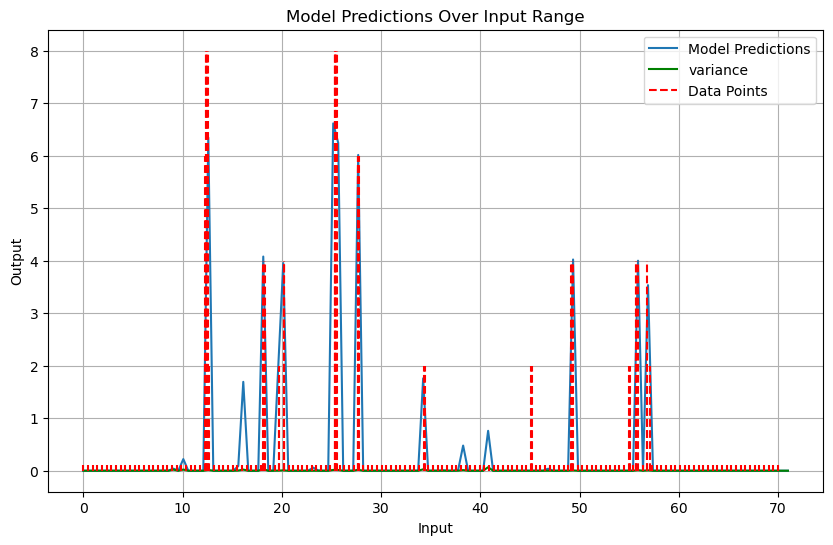

In [29]:
# 11, 10, 4, 0, 13, 15
# good ones: 4=491? , 13=2290, 
selected_user = 3
dataloader, variational_means, variational_logvar, extras = dataloader_list[selected_user]
print(extras["user_id"])
dataset = dataloader.dataset
x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
model.eval()
with torch.no_grad():
    if model_type == "ode":
        raise NotImplementedError
        state = torch.zeros((1, state_size))

        predictions = []
        for el in x_range:
            out = model(state, el)
            predictions.append(out[0])
    else:
        if use_variational_nn:
            predictions_list = []
            for _ in range(20):
                state = torch.tensor(variational_means).repeat(len(x_range),1)
                predictions, states = model(state, x_range_tensor, return_new_state=True)
                predictions = predictions.numpy()
                predictions_list.append(predictions)
                #print("variance of states: ", torch.var(states))
            predictions_list = np.stack(predictions_list)
            predictions = np.mean(predictions_list, axis=0)
            var = np.var(predictions_list, axis=0)
            cond = (0.1>var) | (var <.01)
            #predictions = np.where(cond , predictions, 0)

        else:
            if train_sorted:
                state  = torch.tensor([variational_means])
                for i in range(len(x_range)):
                    curr_t = x_range_tensor[i].view(1,-1)
                    predictions, states = model(state, curr_t, return_new_state=True)
            else:
                state = torch.tensor(variational_means).repeat(len(x_range),1)
                predictions, states = model(state, x_range_tensor, return_new_state=True)
                predictions = predictions.numpy()
                #print("variance of states: ", torch.var(states))

print(f"area: {np.sum(predictions)*(72/200)}")
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

if use_variational_nn:
    plt.plot(x_range, var, label='variance', color="green")

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

user:  2839
area: 4.3154084014892575


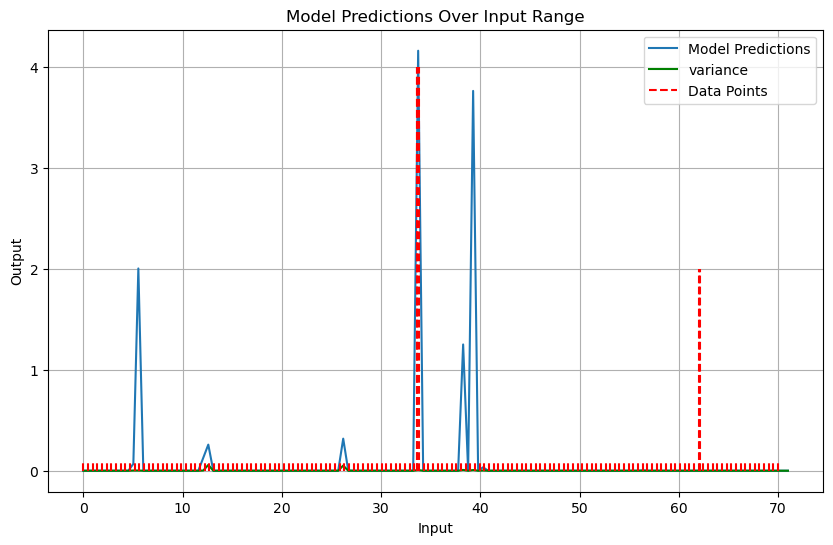

user:  931
area: 14.59716339111328


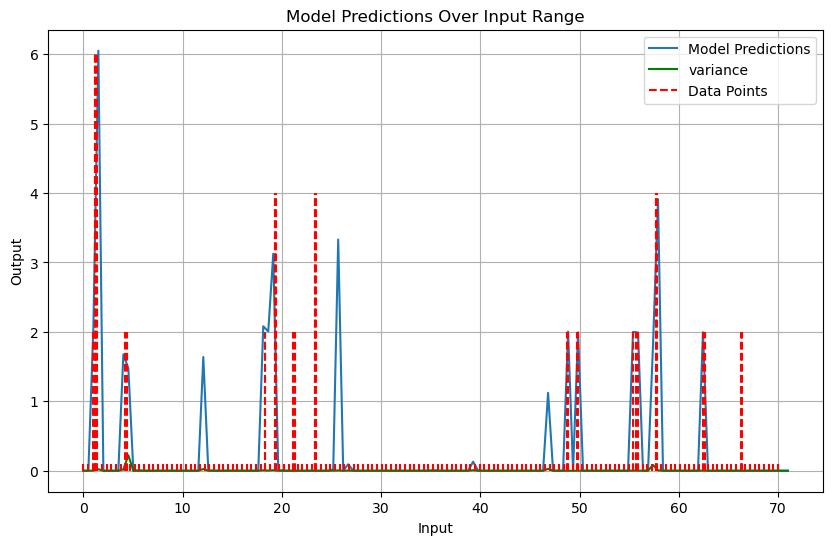

user:  879
area: 44.02788024902343


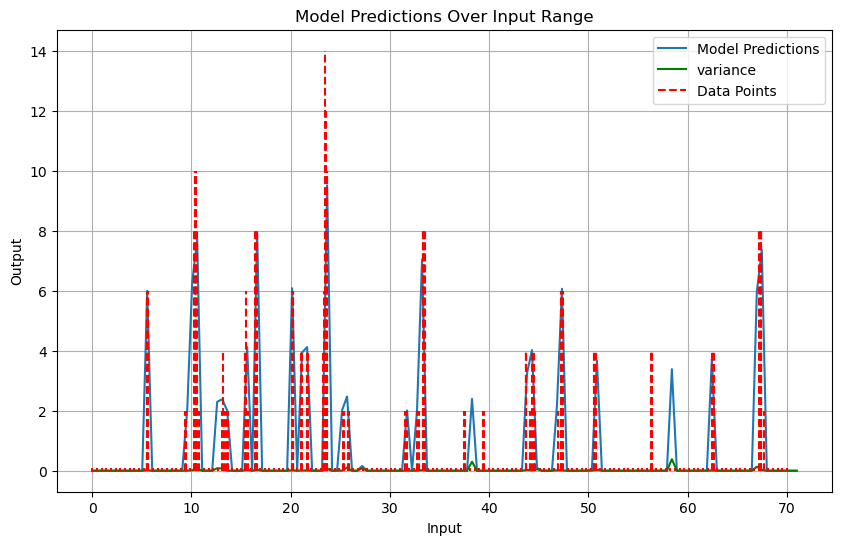

user:  2290
area: 18.63650665283203


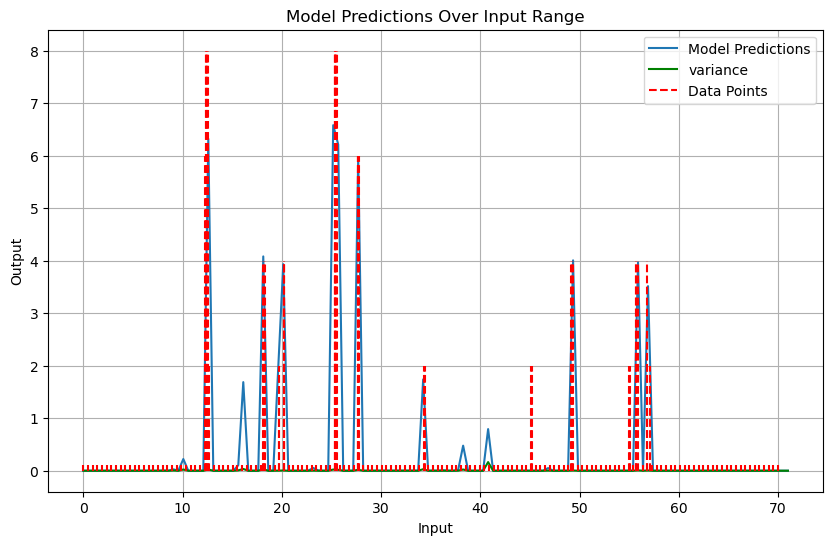

user:  188
area: 4.210819931030273


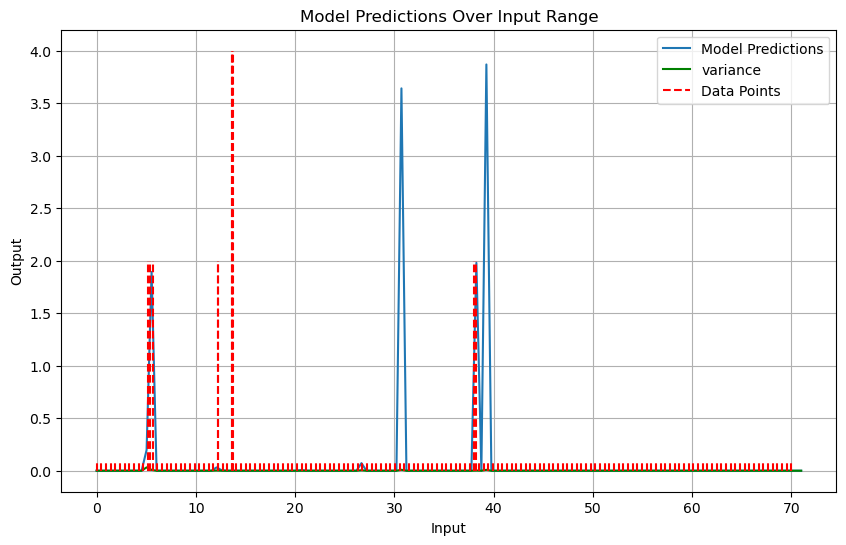

user:  491
area: 10.154133682250976


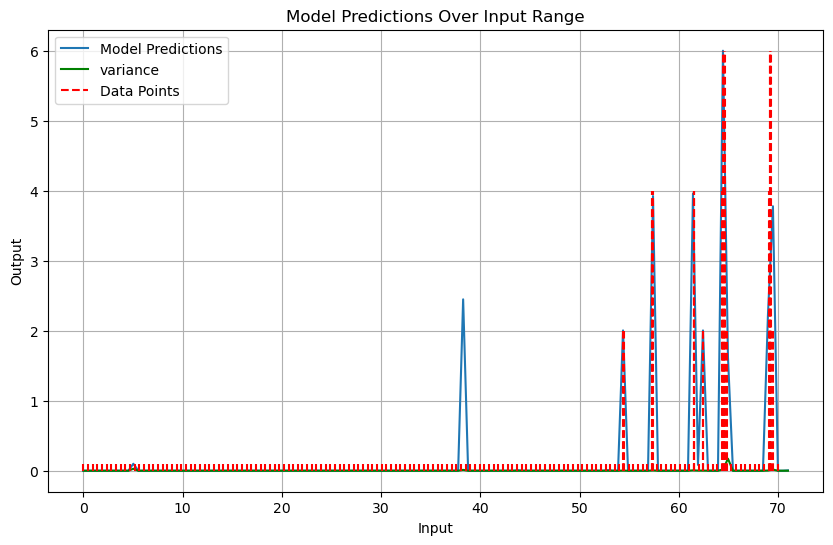

user:  2249
area: 13.081300048828124


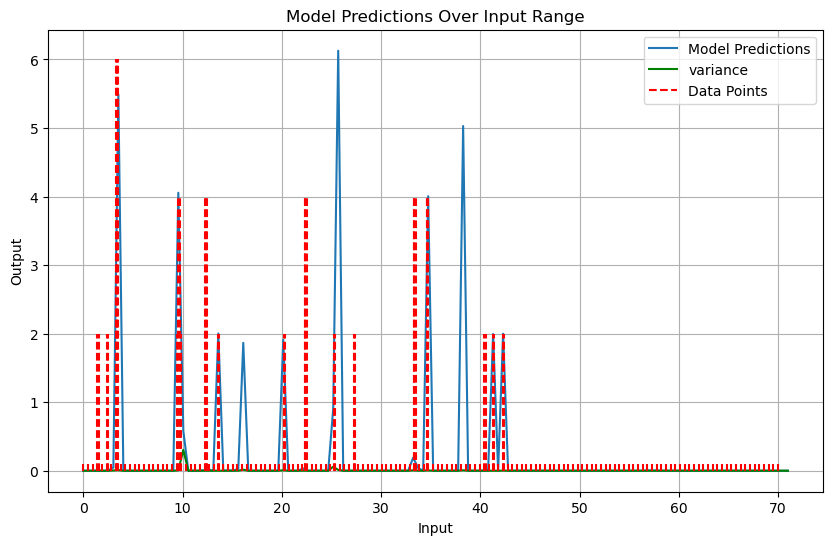

user:  1372
area: 5.140161666870117


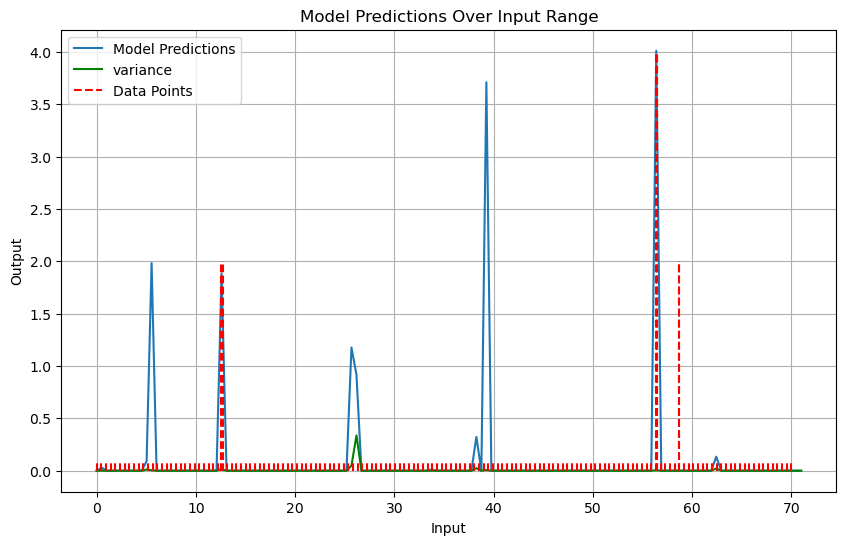

user:  2808
area: 50.90464599609375


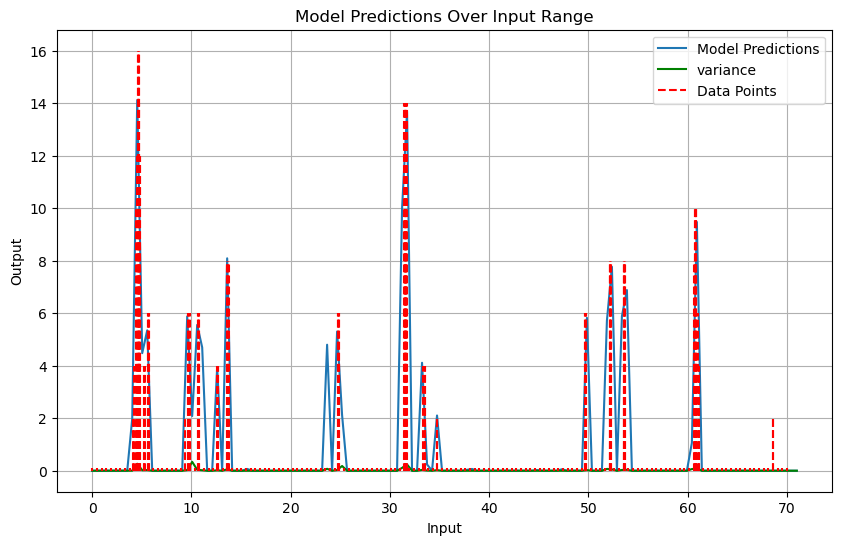

user:  2118
area: 6.583290710449218


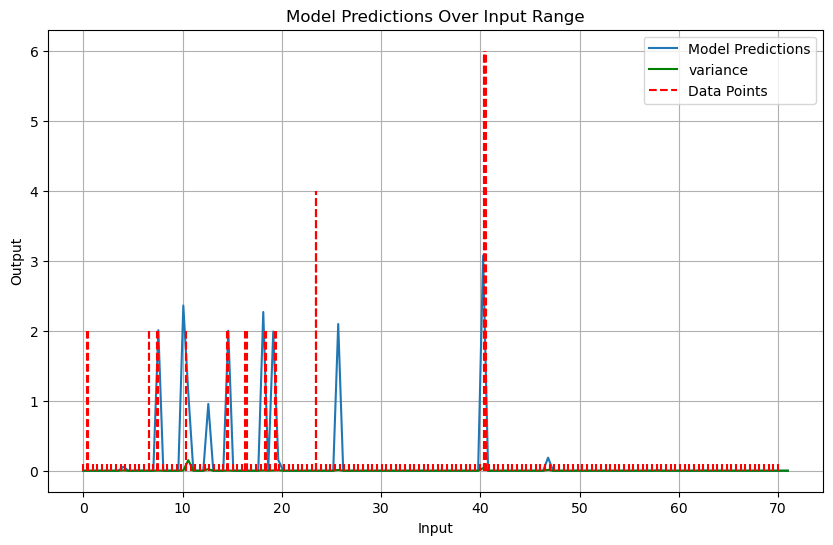

user:  3059
area: 6.856945724487304


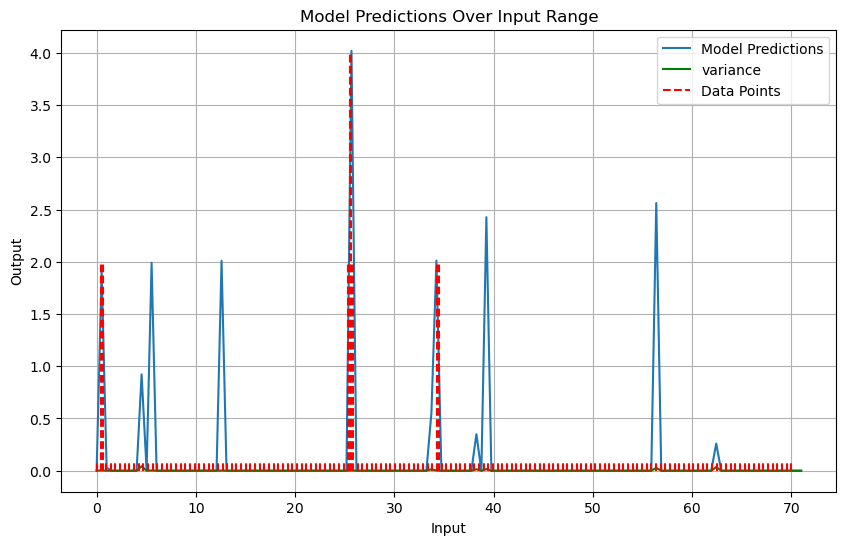

user:  2725
area: 5.206776580810547


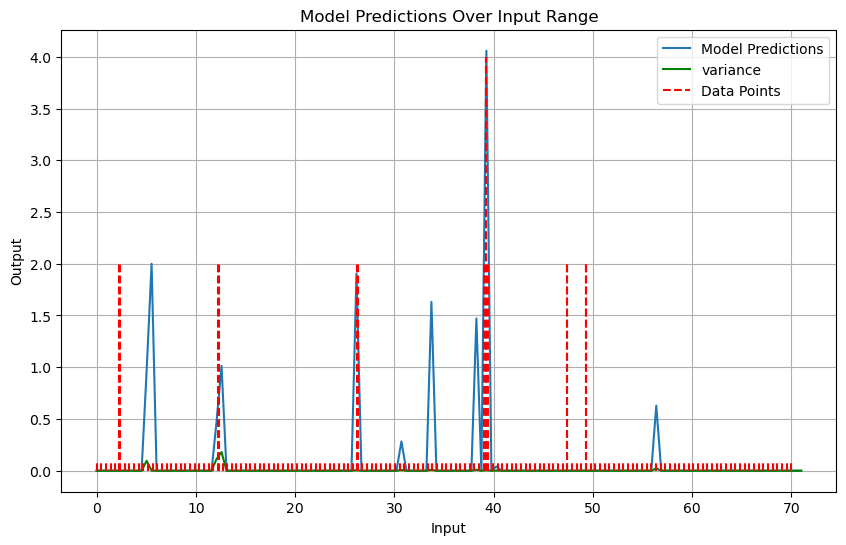

user:  800
area: 5.582551574707031


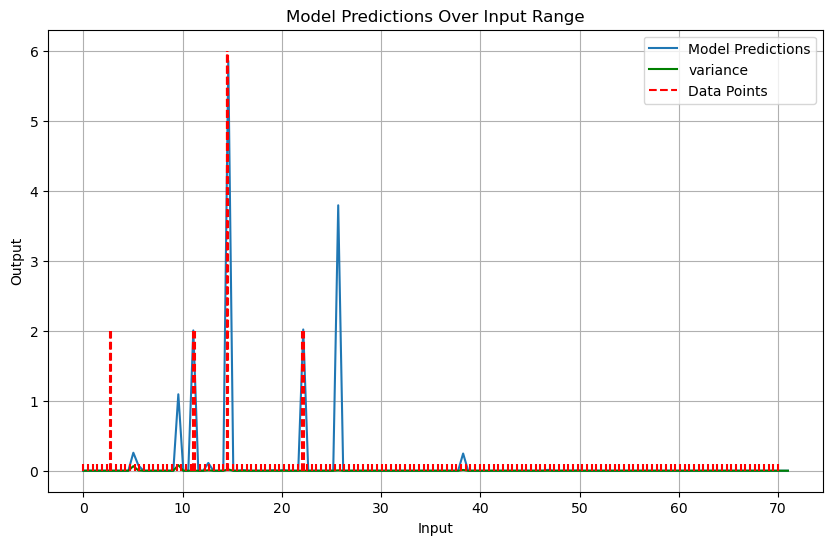

user:  2920
area: 20.224209594726563


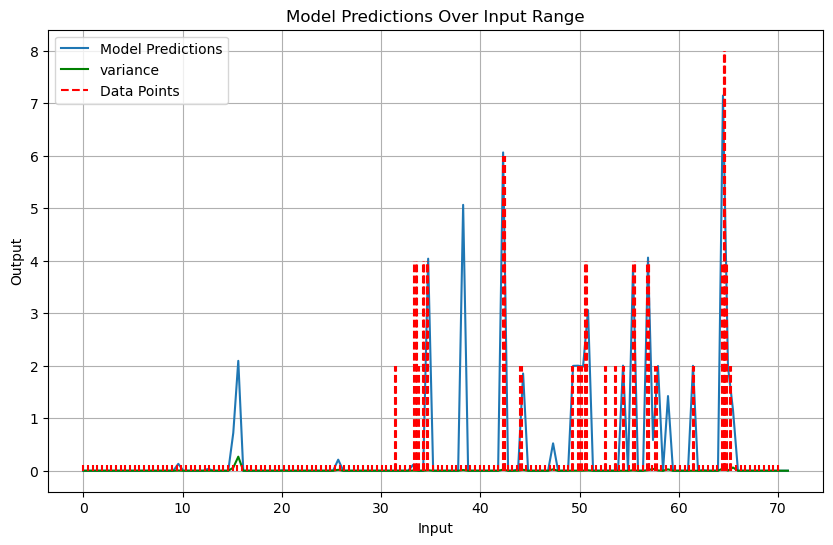

user:  1480
area: 7.528626480102539


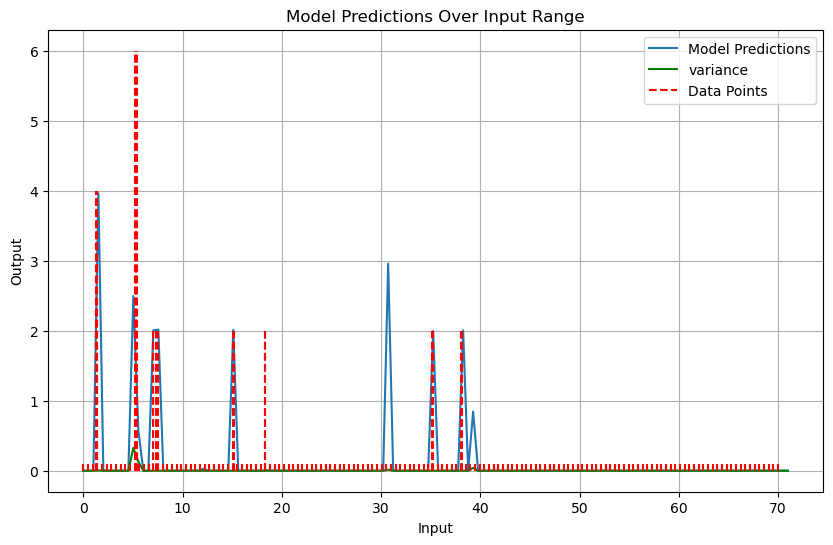

user:  2905
area: 9.122439193725585


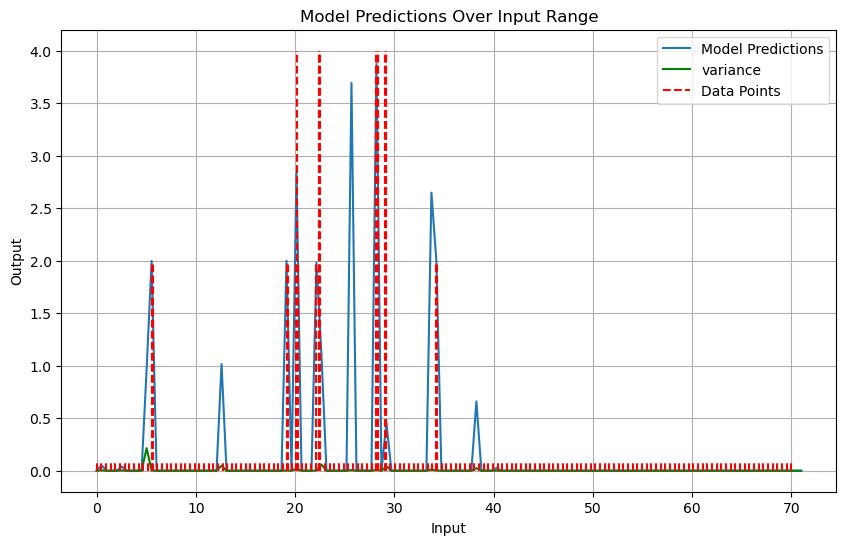

user:  1622
area: 55.58445922851562


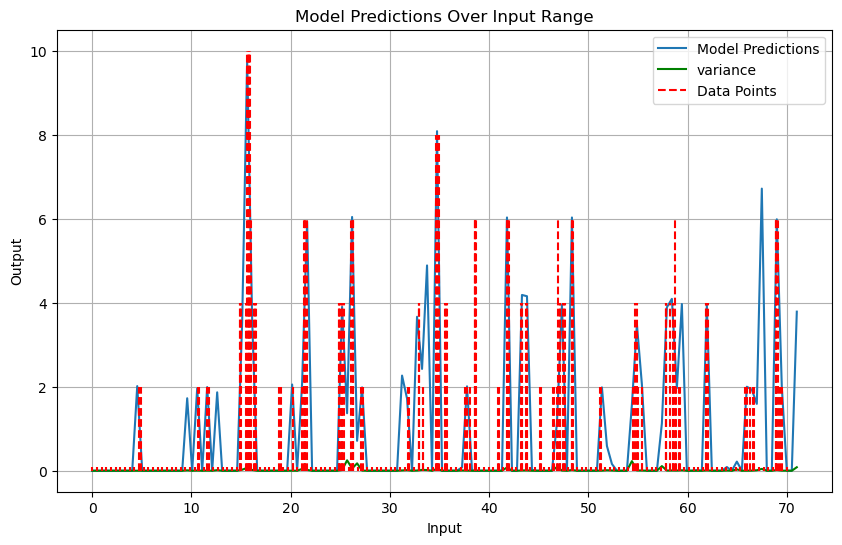

user:  749
area: 5.650586128234863


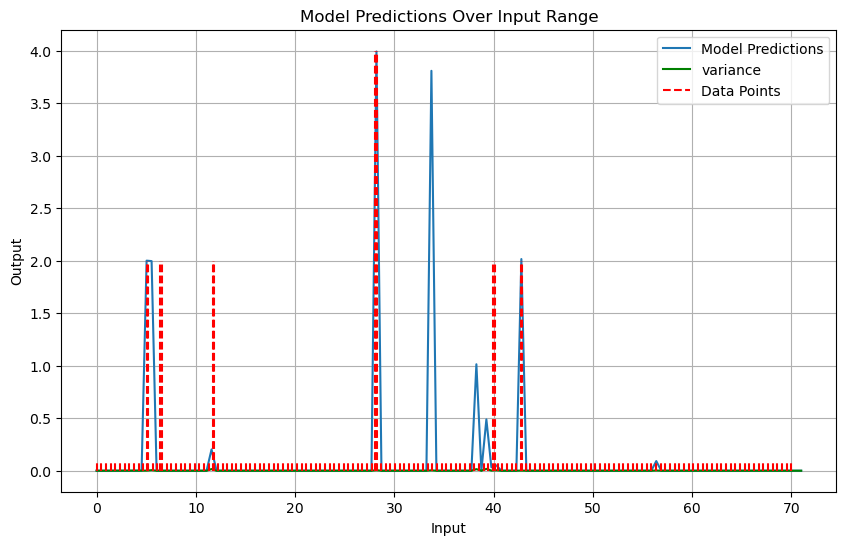

user:  561
area: 5.033200492858887


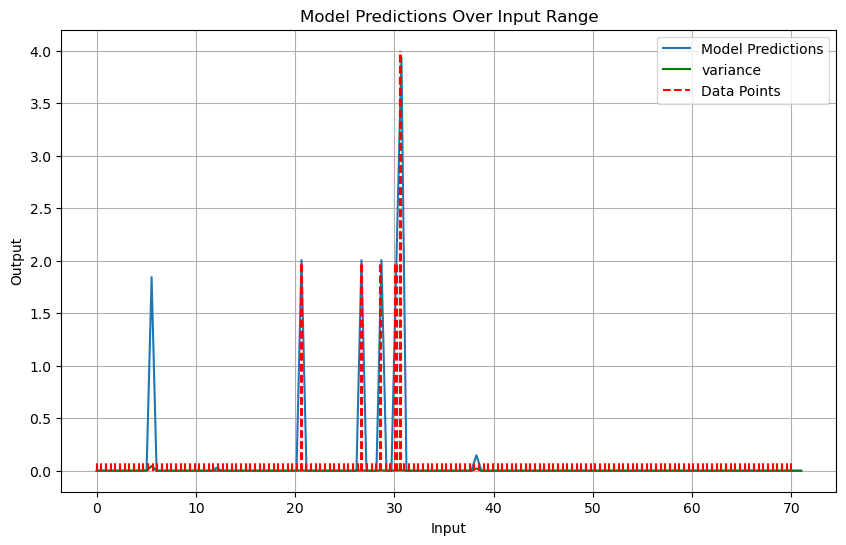

user:  670
area: 10.555536346435547


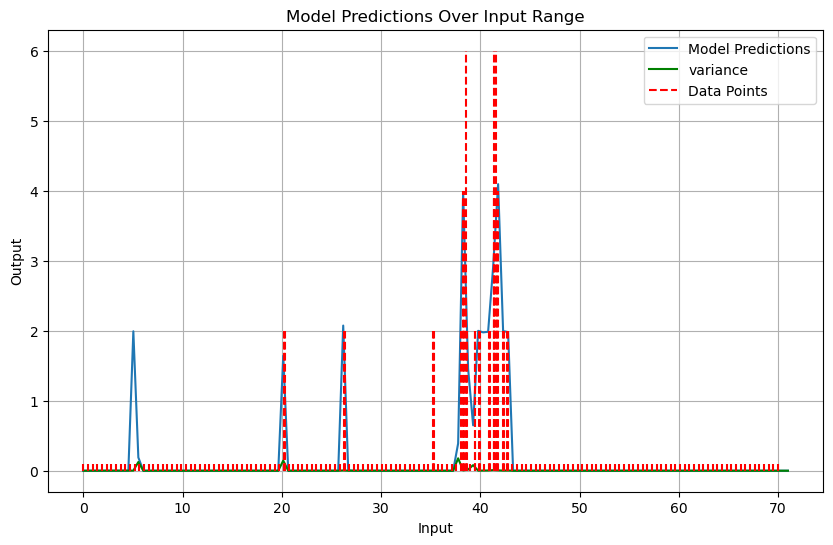

In [27]:
for selected_user in range(len(dataloader_list)):
    # 11, 10, 4, 0, 13, 15
    # good ones: 4=491? , 13=2290, 
    dataloader, variational_means, variational_logvar, extras = dataloader_list[selected_user]
    print("user: ", extras["user_id"])
    dataset = dataloader.dataset
    x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
    x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
    model.eval()
    with torch.no_grad():
        if model_type == "ode":
            raise NotImplementedError
            state = torch.zeros((1, state_size))

            predictions = []
            for el in x_range:
                out = model(state, el)
                predictions.append(out[0])
        else:
            if use_variational_nn:
                predictions_list = []
                for _ in range(20):
                    state = torch.tensor(variational_means).repeat(len(x_range),1)
                    predictions, states = model(state, x_range_tensor, return_new_state=True)
                    predictions = predictions.numpy()
                    predictions_list.append(predictions)
                    #print("variance of states: ", torch.var(states))
                predictions_list = np.stack(predictions_list)
                predictions = np.mean(predictions_list, axis=0)
                var = np.var(predictions_list, axis=0)
                cond = (0.1>var) | (var <.01)
                #predictions = np.where(cond , predictions, 0)


            else:
                state = torch.tensor(variational_means).repeat(len(x_range),1)
                predictions, states = model(state, x_range_tensor, return_new_state=True)
                predictions = predictions.numpy()
                #print("variance of states: ", torch.var(states))

    print(f"area: {np.sum(predictions)*(72/200)}")
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(x_range, predictions, label='Model Predictions')

    if use_variational_nn:
        plt.plot(x_range, var, label='variance', color="green")

    for i in range(len(dataset)):
        sample = dataset[i]
        x_pos= sample['timestep'].item()
        height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
        plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

    plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

    #plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title('Model Predictions Over Input Range')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# ugly version
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

selected_user = 11
dataloader, variational_means, variational_logvar, extras = dataloader_list[selected_user]
print(extras["user_id"])
dataset = dataloader.dataset
x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
model.eval()
with torch.no_grad():
    if model_type == "ode":
        raise NotImplementedError
        state = torch.zeros((1, state_size))

        predictions = []
        for el in x_range:
            out = model(state, el)
            predictions.append(out[0])
    else:
        if use_variational_nn:
            predictions_list = []
            for _ in range(20):
                state = torch.tensor(variational_means).repeat(len(x_range),1)
                predictions, states = model(state, x_range_tensor, return_new_state=True)
                predictions = predictions.numpy()
                predictions_list.append(predictions)
                #print("variance of states: ", torch.var(states))
            predictions_list = np.stack(predictions_list)
            predictions = np.mean(predictions_list, axis=0)
            var = np.var(predictions_list, axis=0)
            cond = (0.1>var) | (var <.01)
            predictions = np.where(cond.any() , predictions, 0)


        else:
            state = torch.tensor(variational_means).repeat(len(x_range),1)
            predictions, states = model(state, x_range_tensor, return_new_state=True)
            predictions = predictions.numpy()
            print("variance of states: ", torch.var(states))

print(f"area: {np.sum(predictions)*(72/200)}")
# Plot the results
plt.plot(x_range, predictions, label='Model Predictions')

if use_variational_nn:
    axs[0].plot(x_range, var, label='variance', color="green")

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sdfsd  # 30 users below

In [ ]:
selected_user = 10
dataloader, variational_means, variational_logvar = dataloader_list[selected_user]
dataset = dataloader.dataset
x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
model.eval()
with torch.no_grad():
    if model_type == "ode":
        raise NotImplementedError
        state = torch.zeros((1, state_size))

        predictions = []
        for el in x_range:
            out = model(state, el)
            predictions.append(out[0])
    else:
        state = torch.tensor(variational_means).repeat(len(x_range),1)
        predictions = model(state, x_range_tensor).numpy()

print(f"area: {np.sum(predictions)*(72/200)}")
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#visualize embeddings
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data = [data[1] for data in dataloader_list]

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Plot the reduced data
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Projection of Embedding space')
plt.grid(True)
plt.show()


In [ ]:
#plot with variances
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.decomposition import PCA

means = [data[1] for data in dataloader_list]
covariances = [np.exp(data[2])*np.eye(state_size) for data in dataloader_list]

colors = plt.cm.rainbow(np.linspace(0, 1, len(means)))

pca = PCA(n_components=2)
reduced_means = pca.fit_transform(means)

def project_covariance(cov, pca):
    return pca.components_ @ (cov ) @ pca.components_.T

reduced_covariances = [project_covariance(cov, pca) for cov in covariances]

# Plotting
fig, ax = plt.subplots()
i =0
for mean, cov in zip(reduced_means, reduced_covariances):
    # Plot the mean
    ax.scatter(mean[0], mean[1], color=colors[i])
    
    # Calculate and plot the 2D Gaussian ellipse
    vals, vecs = np.linalg.eigh(cov)
    width, height = 2 * np.sqrt(vals)
    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                edgecolor=colors[i], fc='None', lw=2)
    i+=1
    ax.add_patch(ellipse)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_title('Projection of User State Parameters')
ax.grid(True)
plt.show()


In [ ]:
assdad

## function Approx. sampling

In [54]:
width=64
use_jump = False
user_state_dict = {"model_hyp": {"layer_width": [width for _ in range(4)]}}
time_dict = {"model_hyp": {"layer_width": [width for _ in range(3)]}
            }
jump_dict= {"model_hyp": {"layer_width": [8, 8]}
            }

timecheat = False
hyperparameter_dict = {"state_size": state_size, "time_model": time_dict, 
                           "state_model": user_state_dict,
                           "time_embedding_size" :32, "max_freq": 30,}

if use_jump:
    hyperparameter_dict["jump_model"]= jump_dict
train_model = all_in_one_model(hyperparameter_dict, timecheat=timecheat, noise_size=1)
print(train_model)

all_in_one_model(
  (time_model): Base_Model(
    (model): Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (embed): SignWaveEmbedding()
  (state_model): Base_Model(
    (model): Sequential(
      (0): Linear(in_features=37, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): SiLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): SiLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): SiLU()
      (8): Linear(in_features=64, out_features=4, bias=True)
    )
  )
)


In [55]:
steps_per_epoch = len(dataloader_list)

num_epochs = 2001
warmup_period = steps_per_epoch * 1
num_steps = num_epochs*steps_per_epoch - warmup_period
num_iter_til_first_restart = (num_steps + 1)//20
user_lr = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(train_model.parameters(), lr=user_lr,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=1e-6)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [56]:
from simtrain.utils import weighted_mse_loss

loss_func_kl=partial(utils.kl_divergence, mu2=0, sigma2=0.01)

In [57]:
train_function_approx_multiple_variational(train_model, path_list, scoring_func=utils.energy_score_loss,
            device=device, user_lr=0.01, user_lr_decay=0.995,
            loss_func_kl=loss_func_kl, kl_weight=kl_weight, logging_shift=1,
            state_size=state_size, warmup_scheduler=warmup_scheduler, lr_scheduler=lr_scheduler,
            optimizer=optimizer, num_epochs=num_epochs, num_tries=30, timecheat=timecheat, 
            loss_print_interval=25, include_jump=use_jump,
            warmup_period=warmup_period)


  0%|          | 1/2001 [00:02<1:11:53,  2.16s/it]/home/thahit/anaconda3/envs/WWcopy/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:1360: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 2/2001 [00:04<1:11:29,  2.15s/it]

epoch: 2 loss_sum_all: 1964.8963, loss_sum_freq: 1927.9386, loss_sum_kl: 36.9577, lr: 0.0009997, userlr: 0.0099500


  1%|▏         | 27/2001 [01:01<1:17:39,  2.36s/it]

epoch: 27 loss_sum_all: 1436.3464, loss_sum_freq: 1410.6031, loss_sum_kl: 25.7434, lr: 0.0008419, userlr: 0.0087781


  3%|▎         | 52/2001 [02:02<1:21:16,  2.50s/it]

epoch: 52 loss_sum_all: 1206.9746, loss_sum_freq: 1142.8307, loss_sum_kl: 64.1439, lr: 0.0004840, userlr: 0.0077442


  4%|▍         | 77/2001 [03:03<1:17:12,  2.41s/it]

epoch: 77 loss_sum_all: 1179.7458, loss_sum_freq: 1102.2614, loss_sum_kl: 77.4844, lr: 0.0001358, userlr: 0.0068321


  5%|▌         | 102/2001 [04:04<1:17:23,  2.45s/it]

epoch: 102 loss_sum_all: 1227.6468, loss_sum_freq: 1157.1985, loss_sum_kl: 70.4483, lr: 0.0009997, userlr: 0.0060274


  6%|▋         | 127/2001 [05:07<1:24:16,  2.70s/it]

epoch: 127 loss_sum_all: 1089.5023, loss_sum_freq: 1020.3110, loss_sum_kl: 69.1913, lr: 0.0008419, userlr: 0.0053175


  8%|▊         | 152/2001 [06:09<1:16:25,  2.48s/it]

epoch: 152 loss_sum_all: 1003.9206, loss_sum_freq: 943.1715, loss_sum_kl: 60.7491, lr: 0.0004840, userlr: 0.0046912


  9%|▉         | 177/2001 [07:05<1:07:26,  2.22s/it]

epoch: 177 loss_sum_all: 872.9622, loss_sum_freq: 819.5940, loss_sum_kl: 53.3682, lr: 0.0001358, userlr: 0.0041387


 10%|█         | 202/2001 [2:54:28<1:53:01,  3.77s/it]     

epoch: 202 loss_sum_all: 909.5513, loss_sum_freq: 858.6021, loss_sum_kl: 50.9492, lr: 0.0009997, userlr: 0.0036512


 11%|█▏        | 227/2001 [2:55:27<1:13:38,  2.49s/it]

epoch: 227 loss_sum_all: 942.6978, loss_sum_freq: 893.5188, loss_sum_kl: 49.1790, lr: 0.0008419, userlr: 0.0032212


 13%|█▎        | 252/2001 [2:56:26<1:05:09,  2.24s/it]

epoch: 252 loss_sum_all: 868.4587, loss_sum_freq: 823.5298, loss_sum_kl: 44.9289, lr: 0.0004840, userlr: 0.0028418


 14%|█▍        | 277/2001 [2:57:22<1:07:17,  2.34s/it]

epoch: 277 loss_sum_all: 809.0007, loss_sum_freq: 766.3690, loss_sum_kl: 42.6318, lr: 0.0001358, userlr: 0.0025071


 15%|█▌        | 302/2001 [2:58:19<1:02:35,  2.21s/it]

epoch: 302 loss_sum_all: 968.3967, loss_sum_freq: 925.3944, loss_sum_kl: 43.0023, lr: 0.0009997, userlr: 0.0022118


 16%|█▋        | 327/2001 [2:59:15<1:09:31,  2.49s/it]

epoch: 327 loss_sum_all: 940.7267, loss_sum_freq: 896.9634, loss_sum_kl: 43.7632, lr: 0.0008419, userlr: 0.0019513


 18%|█▊        | 352/2001 [3:00:17<1:09:03,  2.51s/it]

epoch: 352 loss_sum_all: 875.2798, loss_sum_freq: 833.0444, loss_sum_kl: 42.2354, lr: 0.0004840, userlr: 0.0017215


 19%|█▉        | 377/2001 [3:01:20<1:02:19,  2.30s/it]

epoch: 377 loss_sum_all: 802.1727, loss_sum_freq: 761.6114, loss_sum_kl: 40.5613, lr: 0.0001358, userlr: 0.0015187


 20%|██        | 402/2001 [3:02:28<1:13:59,  2.78s/it]

epoch: 402 loss_sum_all: 898.0573, loss_sum_freq: 857.4508, loss_sum_kl: 40.6064, lr: 0.0009997, userlr: 0.0013398


 21%|██▏       | 427/2001 [3:03:33<1:20:10,  3.06s/it]

epoch: 427 loss_sum_all: 891.7417, loss_sum_freq: 851.2355, loss_sum_kl: 40.5062, lr: 0.0008419, userlr: 0.0011820


 23%|██▎       | 452/2001 [3:04:45<1:25:32,  3.31s/it]

epoch: 452 loss_sum_all: 798.6728, loss_sum_freq: 758.0298, loss_sum_kl: 40.6430, lr: 0.0004840, userlr: 0.0010428


 24%|██▍       | 477/2001 [3:05:52<1:05:09,  2.57s/it]

epoch: 477 loss_sum_all: 741.9123, loss_sum_freq: 701.5271, loss_sum_kl: 40.3852, lr: 0.0001358, userlr: 0.0009200


 25%|██▌       | 502/2001 [3:07:53<1:09:48,  2.79s/it]

epoch: 502 loss_sum_all: 853.1878, loss_sum_freq: 813.4427, loss_sum_kl: 39.7451, lr: 0.0009997, userlr: 0.0008116


 26%|██▋       | 527/2001 [3:08:49<57:17,  2.33s/it]  

epoch: 527 loss_sum_all: 766.6367, loss_sum_freq: 726.9477, loss_sum_kl: 39.6890, lr: 0.0008419, userlr: 0.0007160


 28%|██▊       | 552/2001 [3:09:47<55:45,  2.31s/it]

epoch: 552 loss_sum_all: 834.1213, loss_sum_freq: 795.1255, loss_sum_kl: 38.9957, lr: 0.0004840, userlr: 0.0006317


 29%|██▉       | 577/2001 [3:10:44<54:32,  2.30s/it]

epoch: 577 loss_sum_all: 680.4237, loss_sum_freq: 641.6132, loss_sum_kl: 38.8105, lr: 0.0001358, userlr: 0.0005573


 30%|███       | 602/2001 [3:11:42<54:02,  2.32s/it]

epoch: 602 loss_sum_all: 765.2709, loss_sum_freq: 726.5216, loss_sum_kl: 38.7492, lr: 0.0009997, userlr: 0.0004917


 31%|███▏      | 627/2001 [3:12:39<53:00,  2.32s/it]

epoch: 627 loss_sum_all: 892.9146, loss_sum_freq: 854.0676, loss_sum_kl: 38.8470, lr: 0.0008419, userlr: 0.0004338


 33%|███▎      | 652/2001 [3:13:37<51:16,  2.28s/it]

epoch: 652 loss_sum_all: 687.5557, loss_sum_freq: 648.9636, loss_sum_kl: 38.5922, lr: 0.0004840, userlr: 0.0003827


 34%|███▍      | 677/2001 [3:14:34<50:33,  2.29s/it]

epoch: 677 loss_sum_all: 579.3518, loss_sum_freq: 541.1064, loss_sum_kl: 38.2454, lr: 0.0001358, userlr: 0.0003376


 35%|███▌      | 702/2001 [3:15:32<50:27,  2.33s/it]

epoch: 702 loss_sum_all: 614.3712, loss_sum_freq: 576.2982, loss_sum_kl: 38.0730, lr: 0.0009997, userlr: 0.0002978


 36%|███▋      | 727/2001 [3:16:29<48:49,  2.30s/it]

epoch: 727 loss_sum_all: 655.8361, loss_sum_freq: 617.7468, loss_sum_kl: 38.0893, lr: 0.0008419, userlr: 0.0002628


 38%|███▊      | 752/2001 [3:17:29<47:32,  2.28s/it]

epoch: 752 loss_sum_all: 594.3954, loss_sum_freq: 556.4425, loss_sum_kl: 37.9529, lr: 0.0004840, userlr: 0.0002318


 39%|███▉      | 777/2001 [3:18:26<47:04,  2.31s/it]

epoch: 777 loss_sum_all: 489.7270, loss_sum_freq: 452.0525, loss_sum_kl: 37.6745, lr: 0.0001358, userlr: 0.0002045


 40%|████      | 802/2001 [3:19:24<45:18,  2.27s/it]

epoch: 802 loss_sum_all: 585.5784, loss_sum_freq: 548.1910, loss_sum_kl: 37.3874, lr: 0.0009997, userlr: 0.0001804


 41%|████▏     | 827/2001 [3:20:21<44:40,  2.28s/it]

epoch: 827 loss_sum_all: 632.0830, loss_sum_freq: 594.7561, loss_sum_kl: 37.3269, lr: 0.0008419, userlr: 0.0001592


 43%|████▎     | 852/2001 [3:21:19<43:47,  2.29s/it]

epoch: 852 loss_sum_all: 497.2943, loss_sum_freq: 460.1221, loss_sum_kl: 37.1722, lr: 0.0004840, userlr: 0.0001404


 44%|████▍     | 877/2001 [3:22:19<42:57,  2.29s/it]

epoch: 877 loss_sum_all: 428.8375, loss_sum_freq: 391.8253, loss_sum_kl: 37.0122, lr: 0.0001358, userlr: 0.0001239


 45%|████▌     | 902/2001 [3:23:17<40:47,  2.23s/it]

epoch: 902 loss_sum_all: 493.3444, loss_sum_freq: 456.4193, loss_sum_kl: 36.9250, lr: 0.0009997, userlr: 0.0001093


 46%|████▋     | 927/2001 [3:24:12<39:19,  2.20s/it]

epoch: 927 loss_sum_all: 508.5238, loss_sum_freq: 471.7853, loss_sum_kl: 36.7386, lr: 0.0008419, userlr: 0.0000964


 48%|████▊     | 952/2001 [3:25:07<37:47,  2.16s/it]

epoch: 952 loss_sum_all: 442.0328, loss_sum_freq: 405.3751, loss_sum_kl: 36.6577, lr: 0.0004840, userlr: 0.0000851


 49%|████▉     | 977/2001 [3:26:02<37:30,  2.20s/it]

epoch: 977 loss_sum_all: 377.0555, loss_sum_freq: 340.4938, loss_sum_kl: 36.5617, lr: 0.0001358, userlr: 0.0000750


 50%|█████     | 1002/2001 [3:26:57<36:10,  2.17s/it]

epoch: 1002 loss_sum_all: 455.0490, loss_sum_freq: 418.4417, loss_sum_kl: 36.6072, lr: 0.0009997, userlr: 0.0000662


 51%|█████▏    | 1026/2001 [3:27:50<36:40,  2.26s/it]

epoch: 1027 loss_sum_all: 522.1084, loss_sum_freq: 485.4888, loss_sum_kl: 36.6196, lr: 0.0008419, userlr: 0.0000584
epoch: 1052 loss_sum_all: 410.3369, loss_sum_freq: 373.7854, loss_sum_kl: 36.5515, lr: 0.0004840, userlr: 0.0000515
epoch: 1077 loss_sum_all: 331.0325, loss_sum_freq: 294.5212, loss_sum_kl: 36.5113, lr: 0.0001358, userlr: 0.0000455
epoch: 1102 loss_sum_all: 417.4697, loss_sum_freq: 380.9427, loss_sum_kl: 36.5270, lr: 0.0009997, userlr: 0.0000401
epoch: 1127 loss_sum_all: 402.2500, loss_sum_freq: 365.7720, loss_sum_kl: 36.4780, lr: 0.0008419, userlr: 0.0000354
epoch: 1152 loss_sum_all: 372.5143, loss_sum_freq: 336.0599, loss_sum_kl: 36.4544, lr: 0.0004840, userlr: 0.0000312
epoch: 1177 loss_sum_all: 293.1933, loss_sum_freq: 256.7758, loss_sum_kl: 36.4175, lr: 0.0001358, userlr: 0.0000275
epoch: 1202 loss_sum_all: 408.3954, loss_sum_freq: 371.9999, loss_sum_kl: 36.3955, lr: 0.0009997, userlr: 0.0000243
epoch: 1227 loss_sum_all: 445.6369, loss_sum_freq: 409.2619, loss_sum_kl

100%|██████████| 2001/2001 [2:03:53<00:00,  3.71s/it]

epoch: 2001 loss_sum_all: 180.0133, loss_sum_freq: 143.8989, loss_sum_kl: 36.1144, lr: 0.0010000, userlr: 0.0000004


[(0, 1964.8962707519531, 1927.9386177062988, 36.95767270028591),
 (25, 1436.3464374542236, 1410.6030559539795, 25.743388138711452),
 (50, 1206.9746475219727, 1142.8307342529297, 64.1439111828804),
 (75, 1179.7457904815674, 1102.2614135742188, 77.48437041044235),
 (100, 1227.6468391418457, 1157.1985006332397, 70.4483363032341),
 (125, 1089.5023193359375, 1020.3109836578369, 69.19134184718132),
 (150, 1003.9205551147461, 943.1714820861816, 60.749080523848534),
 (175, 872.9621810913086, 819.5940008163452, 53.368196457624435),
 (200, 909.5512762069702, 858.6020650863647, 50.949209943413734),
 (225, 942.6977891921997, 893.5187754631042, 49.179007202386856),
 (250, 868.4587197303772, 823.529819726944, 44.928912192583084),
 (275, 809.0007448196411, 766.3689548969269, 42.63179570436478),
 (300, 968.3966617584229, 925.3943963050842, 43.00227448344231),
 (325, 940.7266511917114, 896.96342420578, 43.76321838796139),
 (350, 875.2798480987549, 833.044436454773, 42.23540589213371),
 (375, 802.172657

### visualization

In [105]:
def simulate_single_forced_function_approx(model, user_data, state_size, use_jump=False,
                                           timecheat=False, num_tries=20, state=None):
    
    last_t = 0
    if (state is None):
        state = torch.zeros((1, state_size))
    path, variational_means, variational_logvar, reaction_ratio, extra = user_data
    results = []
    with torch.no_grad():
        for interaction_id in range(len(path)):
            timestep = path[interaction_id]
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time=model.get_time(state, last_t)
                else:
                    next_time=model.get_time(state)
                #print(f"next_time: {next_time}, next_state: {next_state}")
                current_pred.append(last_t + next_time[0])
            current_pred = torch.stack(current_pred)
            results.append(torch.mean(current_pred))
            last_t = timestep
            state = model.get_new_state(state, torch.tensor([[timestep]]))
            if use_jump:
                    reactions_ratio_tensor = torch.tensor(reaction_ratio[interaction_id], dtype=torch.float32).view(1,-1)
                    state = model.jump(state, reactions_ratio_tensor)
    
    return results

def simulate_single_function_approx(model, state_size, num_events=10, 
            timecheat=False, num_tries=20, state=None, jump_data=False,):
    #if use_jump:
    #    raise NotImplementedError# what should this do?
    
    last_t = 0
    if (state is None):
        state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for interaction_id in range(num_events):
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time=model.get_time(state, last_t)
                else:
                    next_time=model.get_time(state)
                
                current_pred.append(last_t + next_time[0])
            current_pred = torch.stack(current_pred)
            selected = torch.mean(current_pred)
            results.append(selected)
            last_t = selected
            state = model.get_new_state(state, torch.tensor([[selected]]))
            
            if jump_data:
                reactions_ratio_tensor = torch.tensor(jump_data[interaction_id], dtype=torch.float32).view(1,-1)
                state_new = model.jump(state, reactions_ratio_tensor)
                #print(torch.sum(torch.abs(state_new, state)))
                state = state_new
    
    return results

In [106]:
user_id = 4
sample_path = path_list[user_id]
state = torch.tensor([sample_path[1]])
len(sample_path[0]), state, f"id: {sample_path[4]['user_id']}"

(29, tensor([[ 0.0119, -0.1998,  0.0132,  0.0550]]), 'id: 2920')

In [107]:
# simpler nn
simulate_single_partial_forced_function_approx = partial(
    simulate_single_forced_function_approx, user_data=sample_path,state=state,
                              num_tries=100, timecheat=timecheat, state_size=state_size,
                              use_jump=use_jump)
simulate_single_partial_function_approx = partial(
    simulate_single_function_approx, num_events =len(sample_path[0]), state=state,
                              num_tries=100, timecheat=timecheat, state_size=state_size,
                              jump_data=sample_path[3] if use_jump else False
                              )

In [108]:
# intensity
example_out_forced = simulate_single_partial_forced_function_approx(train_model)
example_out = simulate_single_partial_function_approx(train_model)


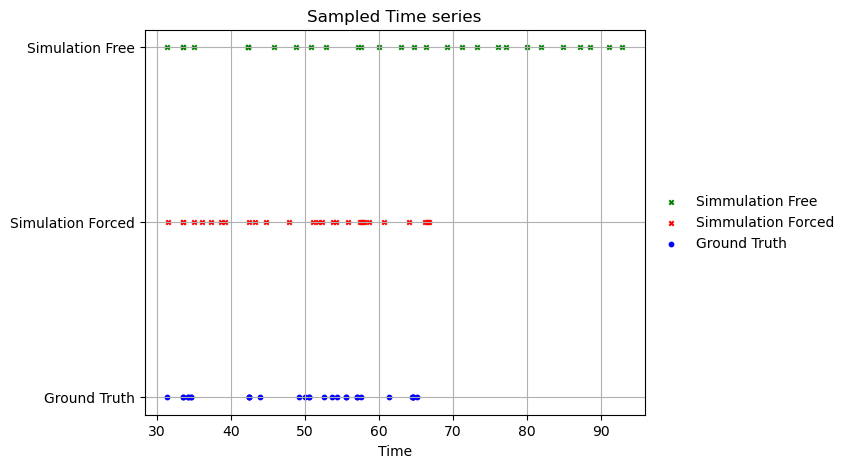

In [104]:
time_series_1 = sample_path[0] # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 1000).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')

ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simulation Forced', "Simulation Free"])
ax.set_title('Sampled Time series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()



1480


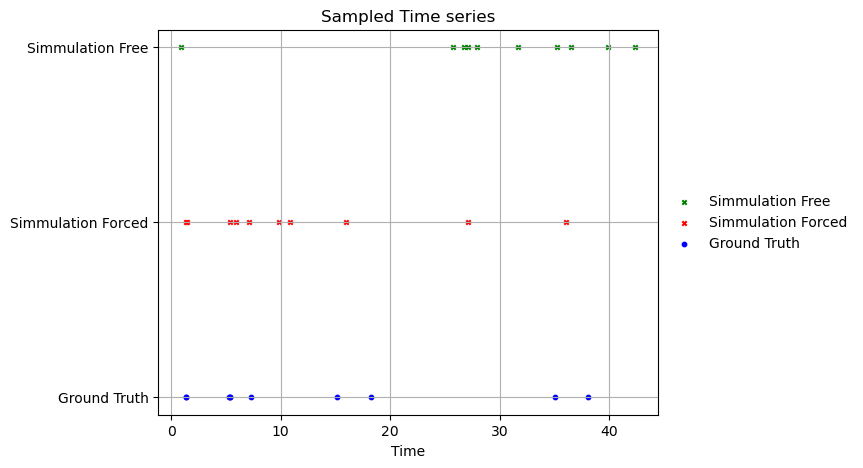

931


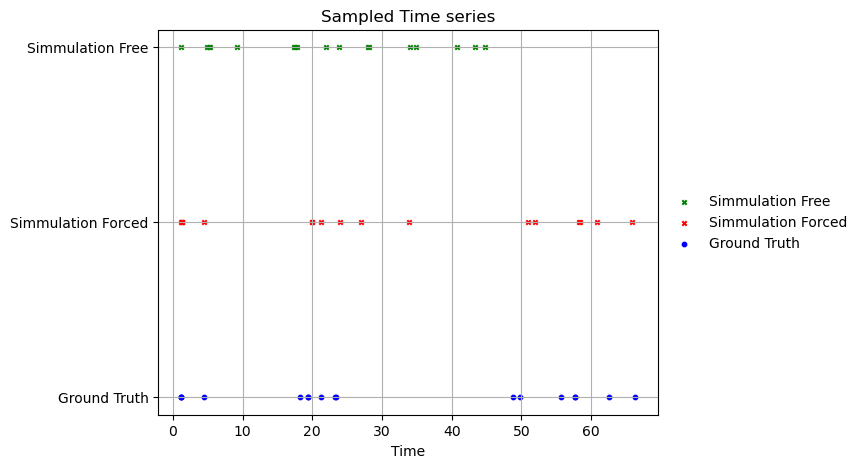

1622


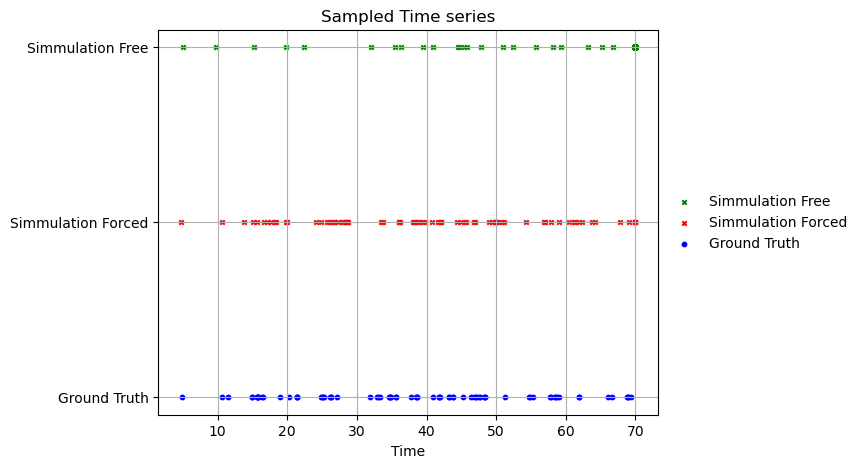

491


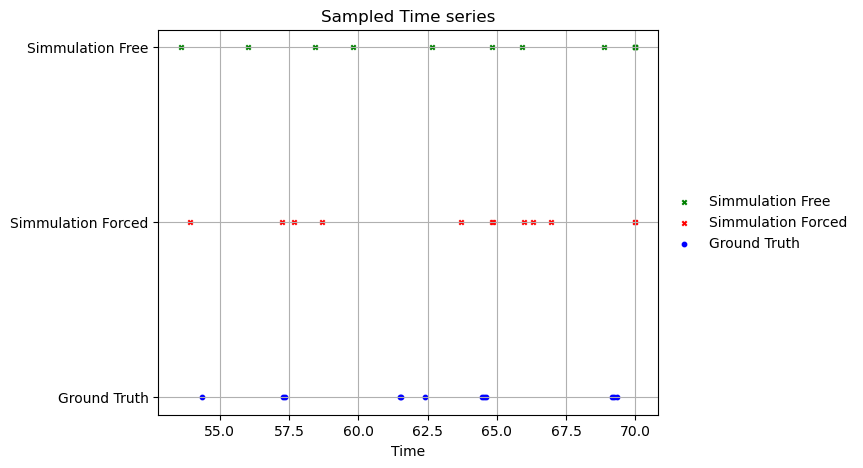

2920


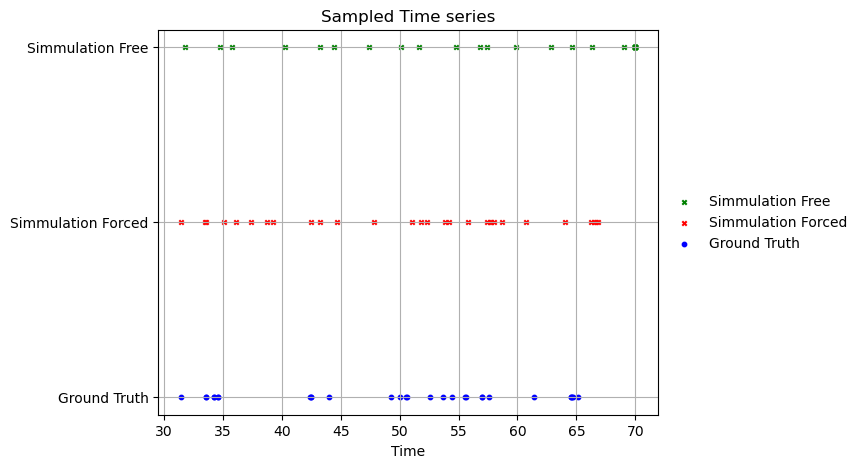

3059


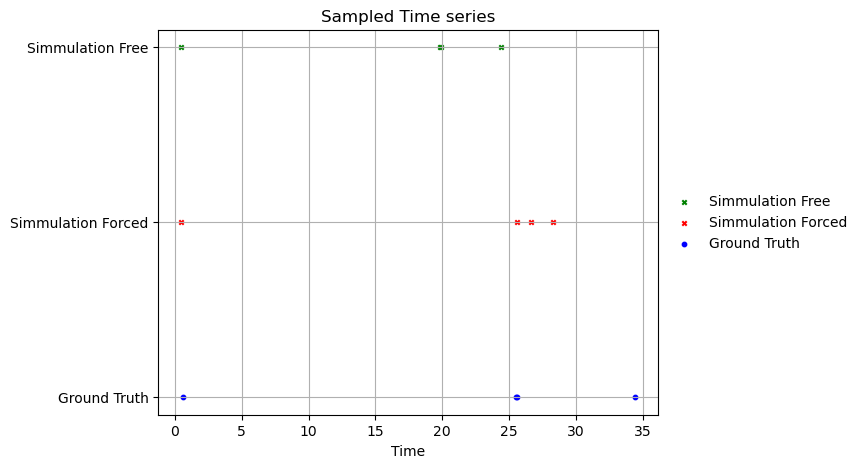

2249


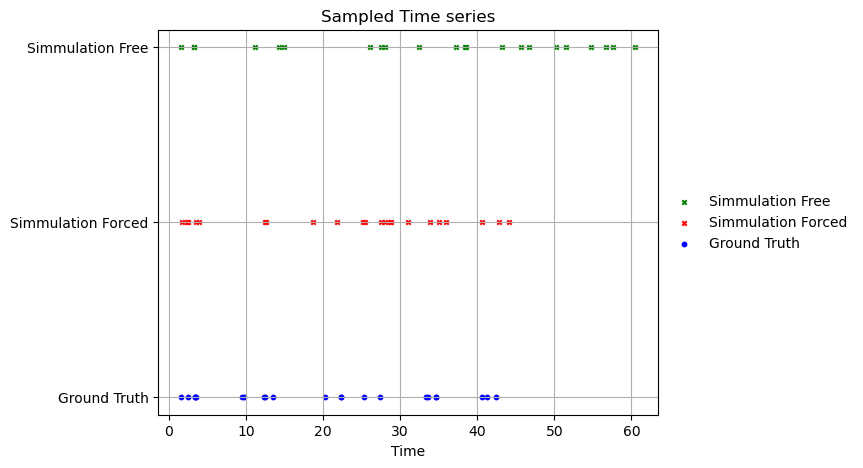

879


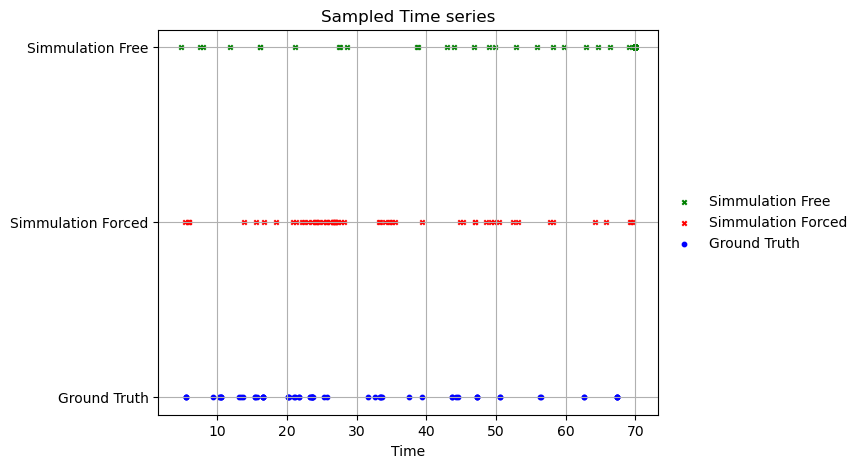

670


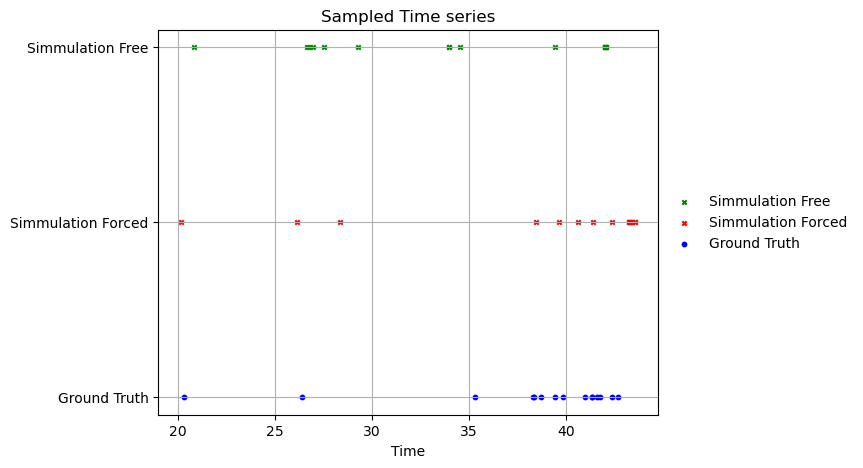

749


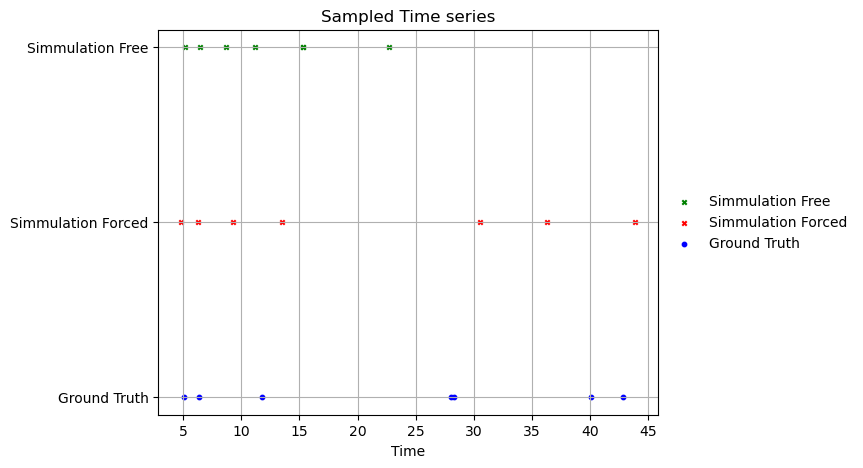

800


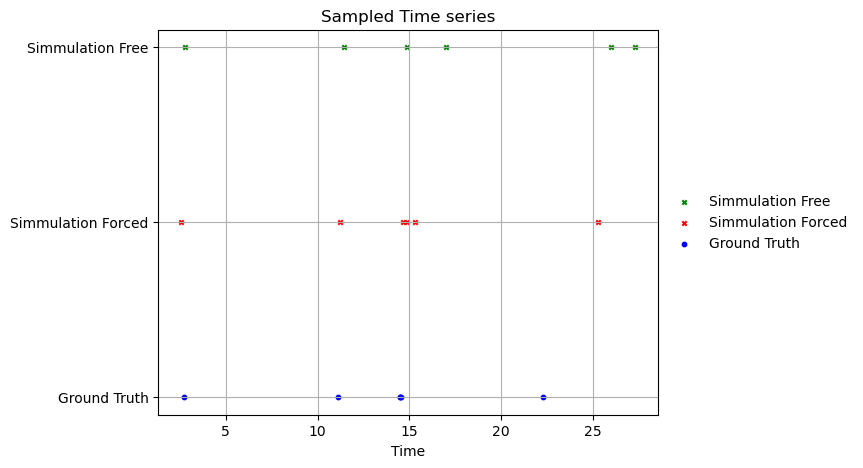

2290


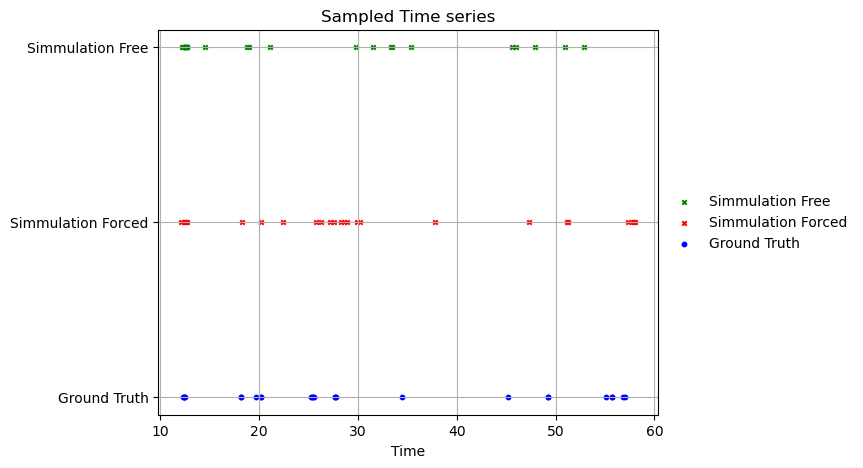

2839


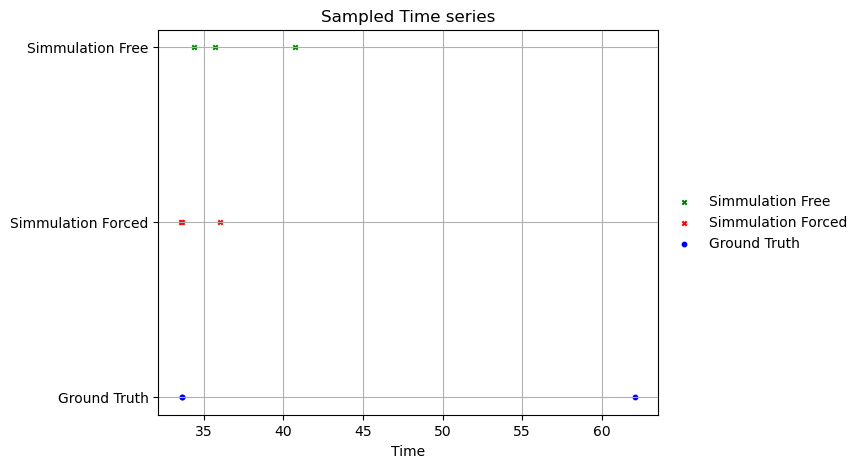

2808


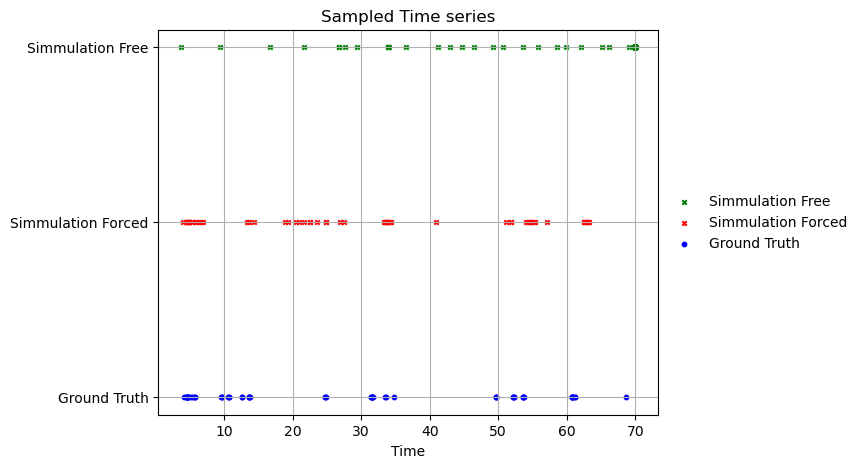

2118


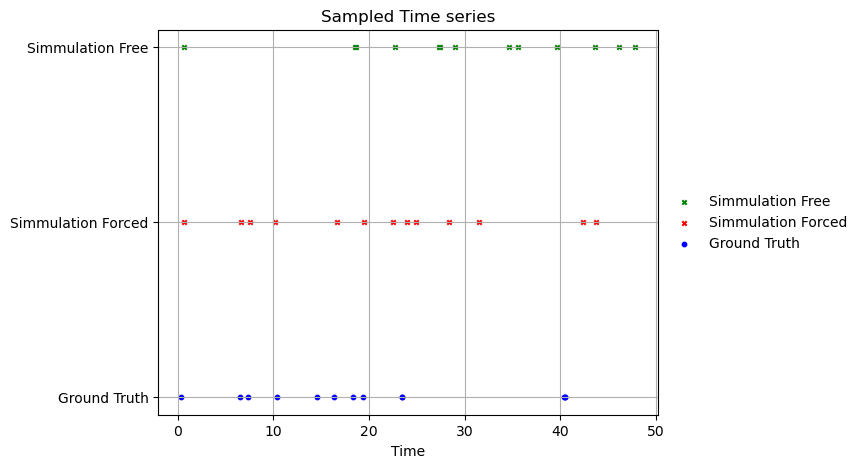

2905


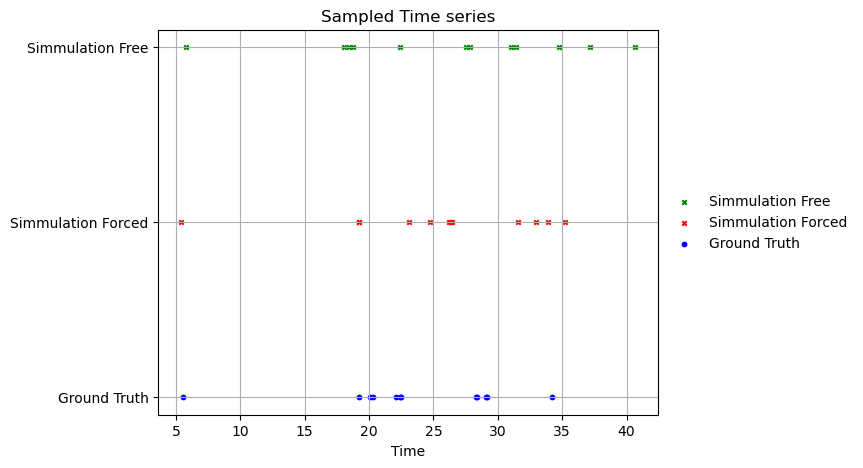

561


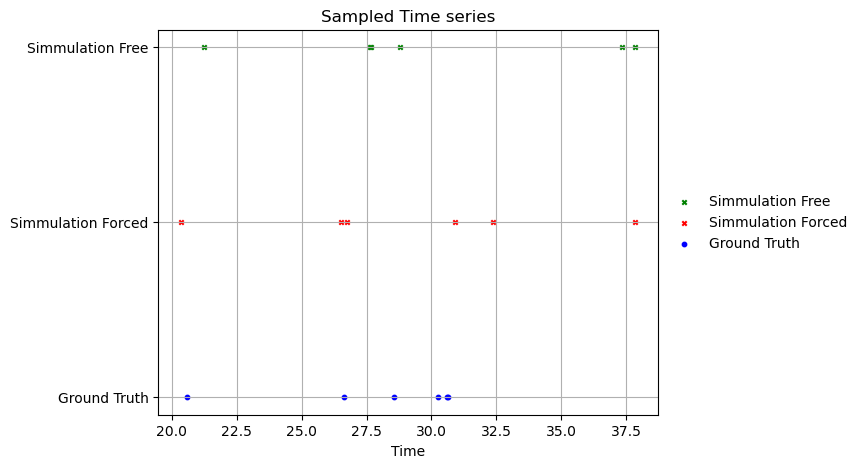

2725


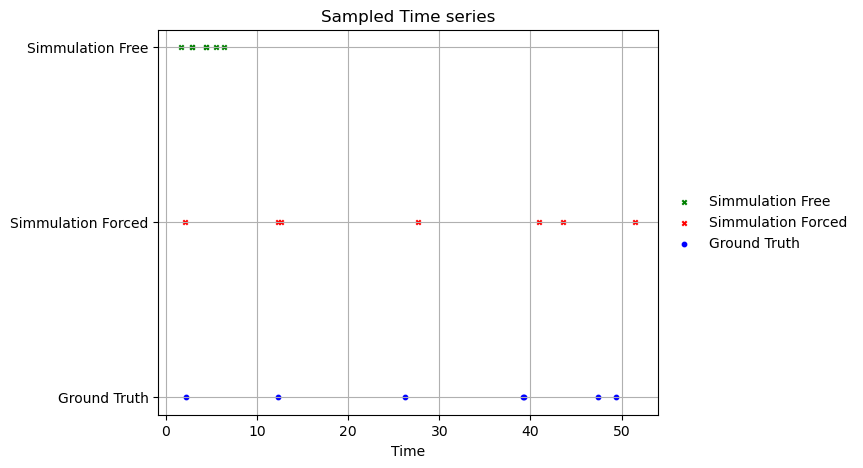

188


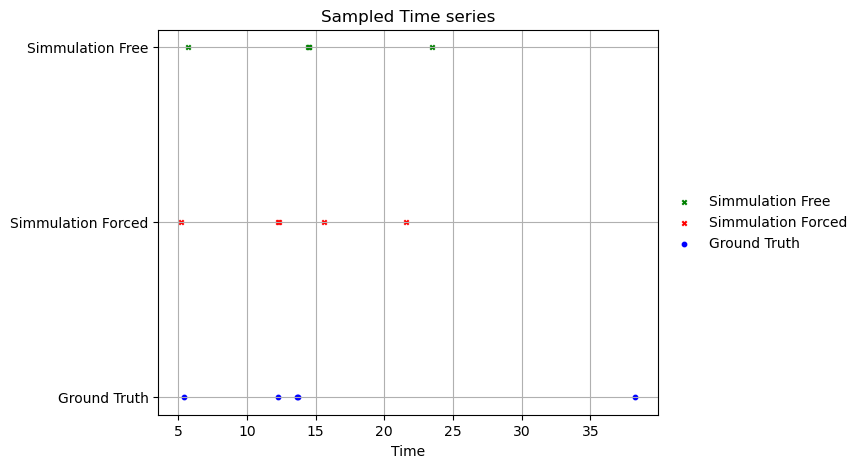

1372


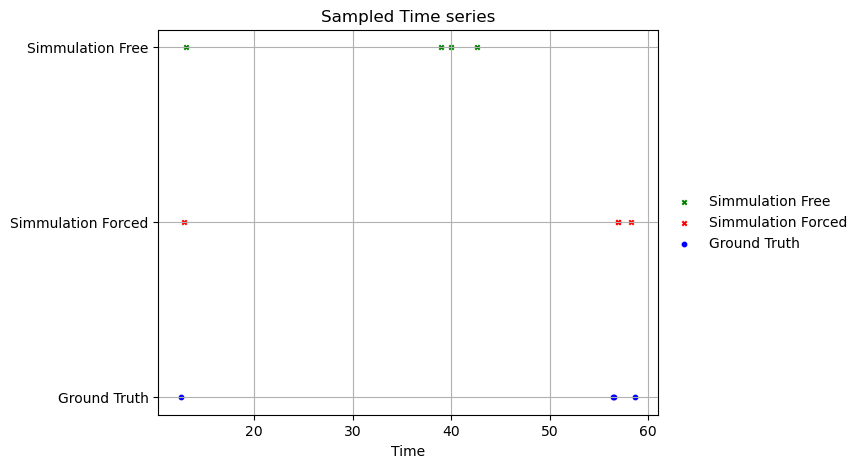

In [100]:
for ind in range(len(path_list)):
    sample_path = path_list[ind]
    print(sample_path[4]["user_id"])
    state = torch.tensor([sample_path[1]])
    # simpler nn
    simulate_single_partial_forced_function_approx = partial(
        simulate_single_forced_function_approx, user_data=sample_path,state=state,
                                num_tries=100, timecheat=timecheat, state_size=state_size,
                                use_jump=use_jump)
    simulate_single_partial_function_approx = partial(
        simulate_single_function_approx, num_events =len(sample_path[0]), state=state,
                                num_tries=1, timecheat=timecheat, state_size=state_size,
                                jump_data=sample_path[3] if use_jump else None)
    # intensity
    example_out_forced = simulate_single_partial_forced_function_approx(train_model)
    example_out = simulate_single_partial_function_approx(train_model)

    time_series_1 = sample_path[0] # Timestamps for the first time series
    time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
    time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')

    ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')
    ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')



    # Add labels, legend, and grid
    ax.set_xlabel('Time')
    ax.set_yticks([1, 2, 3])
    ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Free"])
    ax.set_title('Sampled Time series')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

    # Adjust subplot parameters to make room for the legend
    plt.subplots_adjust(right=0.75)
    ax.grid(True)

    # Display the plot
    plt.show()



# Combined Models old

In [ ]:
# parameter dicts
width= 32
user_state_dict = {"model_hyp": {"layer_width": [width, width, width]}}
intensity_state_dict = {"model_hyp": {"user_model_hyp": {"layer_width": [width, width],
                                        "noise": 0},
                        "global_model_hyp": {"layer_width": [width, 3]}}
                            }
interaction_state_dict = {"model_hyp": {"layer_width": [width, width ,width]}
                            }
jump_state_dict = {"model_hyp": {"layer_width": [width, width]}
                        }

In [ ]:
import torch.optim as optim

hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, "num_interaction_outcomes": num_interaction_types,
        "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
        "recom_dim":recom_dim, "interaction_model": interaction_state_dict,
        "jump_model": jump_state_dict, "user_params_size": state_size,
        "noise": .01}
model = User_simmulation_Model(hyperparameter_dict)
#model = Conditioned_User_simmulation_Model(hyperparameter_dict)

In [ ]:
# load model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                 experiment_name, "user_model.h5")
model.load_state_dict(torch.load(path))

In [ ]:
num_epochs = 10
warmup_period = len(dataset)
num_steps = num_epochs*len(dataset) -warmup_period
num_iter_til_first_restart = num_steps//2
user_lr = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=0.01,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=5e-5)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


In [ ]:
utils.print_user_params(dataloader, print_var = True)

In [ ]:
# no negative samples
with torch.autograd.set_detect_anomaly(True):
        train(model, dataloader=dataloader, num_epochs=num_epochs, device=device, loss_func=utils.loss_func, 
                loss_func_kl=utils.kl_loss, kl_weight=kl_weight, user_lr=user_lr, conditioned=conditioned,
                optimizer=optimizer, lr_scheduler=lr_scheduler, num_classes=num_interaction_types, 
                logger=utils.logging_func, warmup_period=warmup_period, 
                intensity_loss_func=utils.square_intensity_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                )


In [ ]:
adsaf 

In [ ]:
train_with_negatives(model, dataloader=dataloader, num_epochs=num_epochs, device=device, 
                loss_func=utils.loss_func, loss_func_kl=utils.kl_loss, kl_weight=kl_weight, 
                user_lr=user_lr, optimizer=optimizer, lr_scheduler=lr_scheduler, 
                num_classes=num_interaction_types, logger=utils.logging_func,
                warmup_period=warmup_period, intensity_loss_func=utils.log_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                num_negatives=num_negatives, positive_examples_weight=5,conditioned=conditioned,
                )

In [ ]:
utils.print_user_params(dataloader, print_var = True)

In [ ]:
#save model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "user_model.h5")

torch.save(model.state_dict(), path)

In [ ]:
# save data(changes during training)
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "data.h5")
torch.save({
    'data': dataloader.dataset.data,
}, path,
)


## visualize

In [ ]:
# conditioned square continouous state + state_int new formulas
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, 
                dataset=dataloader.dataset, User_model = model, use_true_recommendations =True, 
                num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

In [ ]:
# conditioned square continouous state + state_int
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

In [ ]:
# conditioned square continouous state
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

In [ ]:
# conditioned negative
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

In [ ]:
# conditioned_square
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=conditioned, increment=.5)

In [ ]:
# negative sampling  larger intervals
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=False, increment=.5)

In [ ]:
# square  larger intervals train longer
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=False, increment=.2)

In [ ]:
# square  larger intervals
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=1, conditioned=False, increment=.2)

In [ ]:
# square continuous state integral
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=False)

In [ ]:
# negative conditioned
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=True)

In [ ]:
# square conditioned
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=True)

In [ ]:
# square
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2)

In [ ]:
#negative
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=1)